In [138]:
%matplotlib inline
%load_ext lab_black

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import missingno as msno
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
import tensorflow as tf
import IPython
from sklearn.base import BaseEstimator, RegressorMixin, clone

from shared import process_single_site, process_multi_site
from plot import (
    plot_timeline,
    plot_desity_and_errors,
    pred_plot,
    error_per_month_and_year,
)
from shared import HistoryKerasRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor, ColumnTransformer
from tensorflow import keras
from model import eval_model, make_grid, hyperparam_graph, hyperparam_plot, plot_net_training_curves
import missingno as msno
from shared import daylength, solar_altitude
from sklearn.model_selection import train_test_split
from extra import ding
from lstm import WindowRegressor, WindowGenerator, compile_and_fit, prepare_splits

resources = "resources/"

data_path = os.path.join(resources, "data.csv.gz")
metadata_path = os.path.join(resources, "fdk_site_info.csv")
test_path = os.path.join(resources, "full_time_series.csv.gz")

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


# LSTM

In [76]:
MAX_WINDOW = 64
process_multi_site(data_path, metadata_path, qc_threshold=0.5, show_na=True, window_size=MAX_WINDOW)

Number of sites: 58
Sample count: 221353


In [116]:
X_tv, y_tv, X_test, y_test = prepare_splits(df_prep, MAX_WINDOW)
print(X_tv.shape)
print(X_test.shape)
df_pred = pd.DataFrame()
df_pred["True GPP"] = y_test.copy()
df_pred["baseline"] = df_pred["True GPP"]

(71296, 15)
(17856, 15)


Loading the data
Loading metadata and joining
Adding GPP and GPP_diff
Dropping unused features
Removing bad values
Adding engineered features
Remove unused features
NA: 48


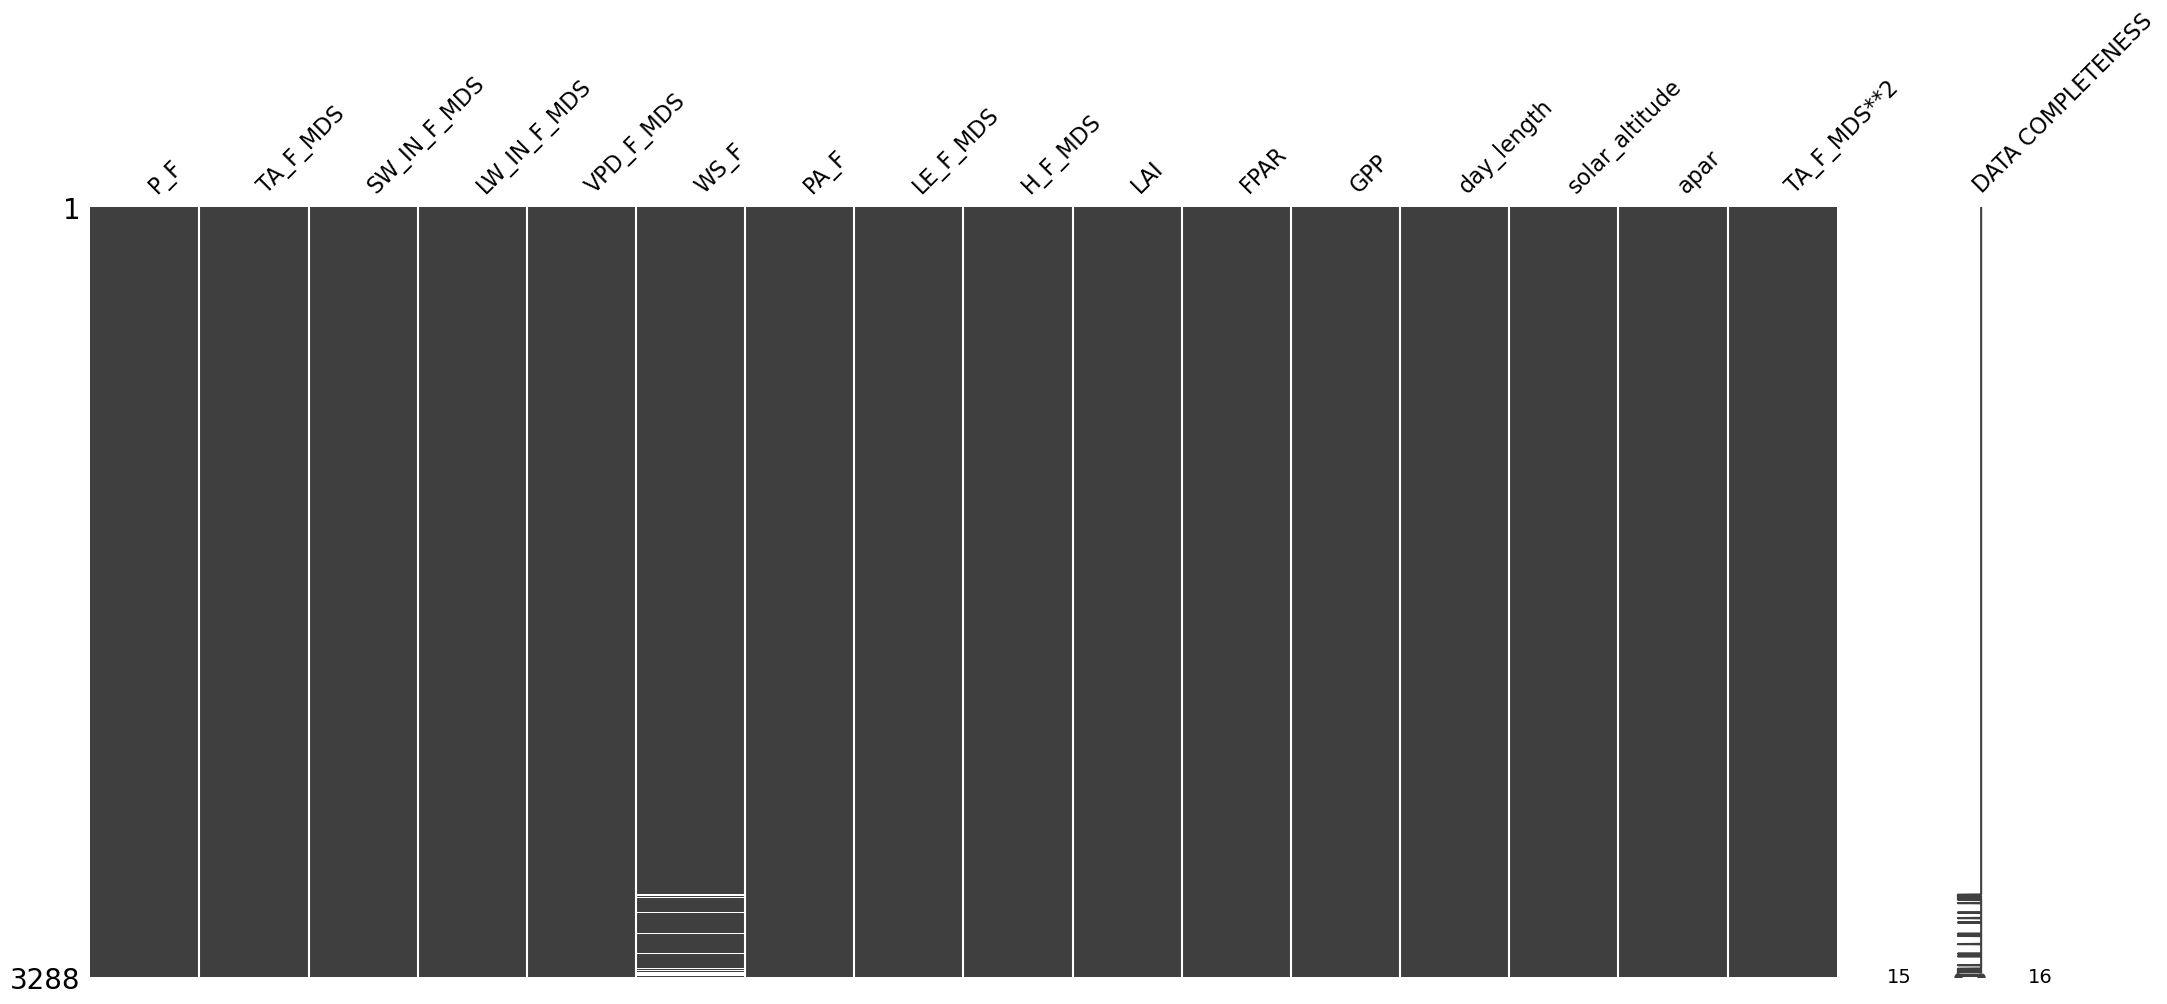

In [118]:
df_test = process_single_site(test_path, metadata_path, with_rolling_windows=False, interpolate=True)

In [119]:
print(df_test.shape)
# It must be a multiple of 64
new_size = (len(df_test) // MAX_WINDOW) * MAX_WINDOW
df_test = df_test.head(new_size)
print(df_test.shape)

df_pred_test = pd.DataFrame()
df_pred_test["True GPP"] = df_test["GPP"].copy()

NA: 0
(3288, 16)
(3264, 16)


## 1 layer

In [172]:
def model_fun(
    lstm_units,
    learning_rate,
    dropout=0,
    recurrent_dropout=0,
    kernel_regularizer=0,
    recurrent_regularizer=0,
    seed=0,
):
    model = tf.keras.models.Sequential(
        [
            # Shape [batch, time, features] => [batch, time, lstm_units]
            tf.keras.layers.LSTM(
                lstm_units,
                return_sequences=True,
                dropout=dropout,
                recurrent_dropout=recurrent_dropout,
                kernel_regularizer=tf.keras.regularizers.L2(kernel_regularizer),
                recurrent_regularizer=tf.keras.regularizers.L2(recurrent_regularizer),
                # seed=seed
            ),
            # Shape => [batch, time, features]
            tf.keras.layers.Dense(units=1),
        ]
    )
    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        metrics=[tf.keras.metrics.MeanAbsoluteError()],
    )
    # model.summary()
    return model

In [175]:
def build_model():
    regressor = WindowRegressor(
        HistoryKerasRegressor(
            model_fun,
            verbose=1,
            shuffle=False,
            epochs=100,
            callbacks=[keras.callbacks.EarlyStopping(patience=4, mode="min")],
        ),
        window_size=1,
    )
    return regressor

#### n=32, l=5

Fitting 1 folds for each of 1 candidates, totalling 1 fits
Epoch 1/100
223/223 [==============================] - 5s 13ms/step - loss: 0.6679 - mean_absolute_error: 0.6157 - val_loss: 0.3745 - val_mean_absolute_error: 0.4642
Epoch 2/100
223/223 [==============================] - 2s 10ms/step - loss: 0.3476 - mean_absolute_error: 0.4391 - val_loss: 0.3006 - val_mean_absolute_error: 0.4142
Epoch 3/100
223/223 [==============================] - 3s 13ms/step - loss: 0.2952 - mean_absolute_error: 0.4008 - val_loss: 0.2728 - val_mean_absolute_error: 0.3897
Epoch 4/100
223/223 [==============================] - 3s 13ms/step - loss: 0.2700 - mean_absolute_error: 0.3798 - val_loss: 0.2562 - val_mean_absolute_error: 0.3739
Epoch 5/100
223/223 [==============================] - 2s 11ms/step - loss: 0.2546 - mean_absolute_error: 0.3660 - val_loss: 0.2454 - val_mean_absolute_error: 0.3631
Epoch 6/100
223/223 [==============================] - 3s 11ms/step - loss: 0.2444 - mean_absolute_error: 0.356

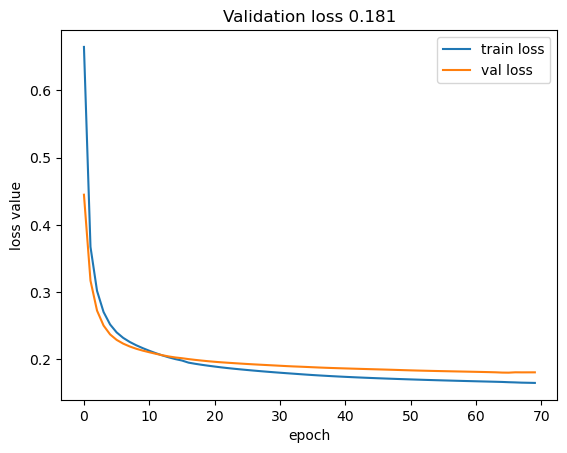

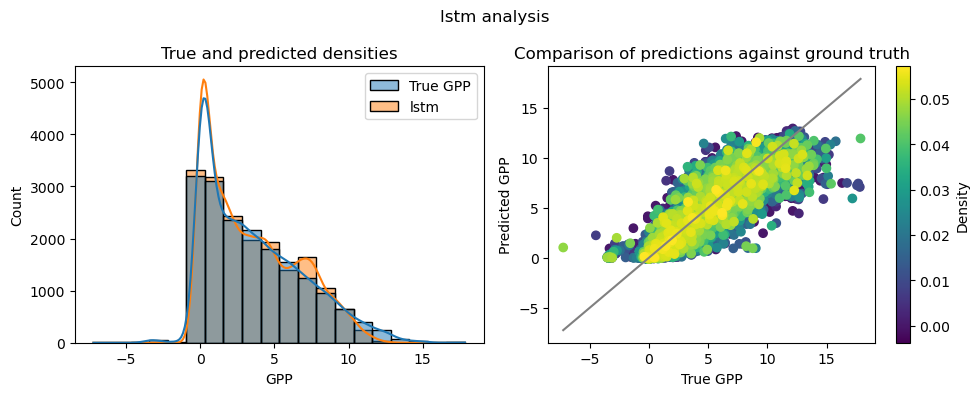

----
Predicting Test...
102/102 [==============================] - 0s 2ms/step
Prediction time: 0.49s
Score (Test): 0.83
MAE (Test): 0.99
RMSE (Test): 1.83


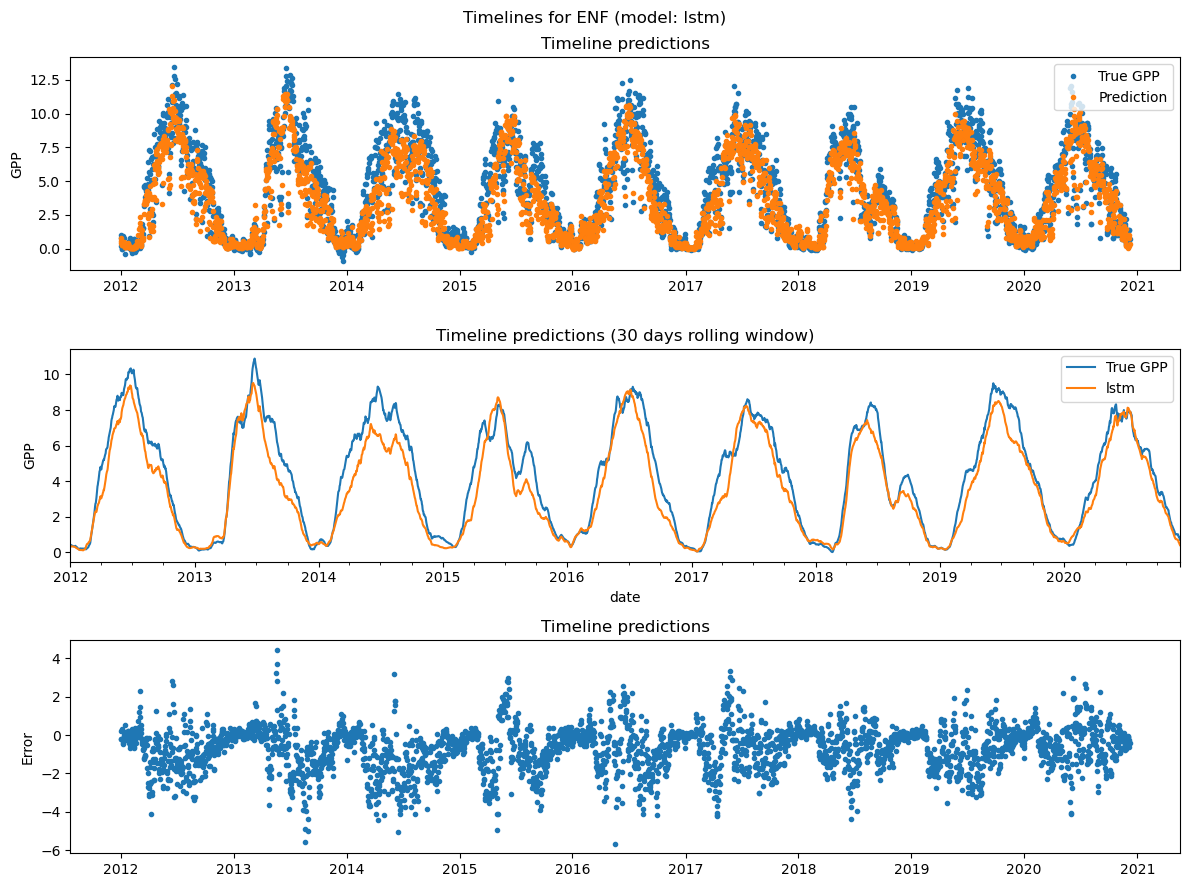

In [177]:
name = "lstm"

grid = make_grid(
    [
        QuantileTransformer(output_distribution="normal"),
    ],
    {
        "reg__window_size": [MAX_WINDOW],
        "reg__window_size": [32],
        "reg__regressor__learning_rate": [0.001],
        "reg__regressor__lstm_units": [5],
        "reg__regressor__epochs": [100],
    },
)

model, df_pred[name], pred_time, r2, mae, rmse = eval_model(
    None,
    build_model(),
    grid,
    X_tv,
    y_tv,
    X_test,
    y_test,
    verbose=2,
    n_splits=0,
    n_jobs=1,
)
plot_net_training_curves(model.best_estimator_.regressor_.named_steps.reg.regressor.history)
# plot_timeline(df_pred, name, "ENF")
pred_plot(df_pred, name)
df_pred_test[name], _, _, _, _ = compute_metrics(
    model, df_test.drop(["GPP"], axis=1), df_pred_test["True GPP"], label="Test"
)
plot_timeline(df_pred_test, name, "ENF")

#### n=2-64, l=1-5

Fitting 1 folds for each of 30 candidates, totalling 30 fits
[CV] END regressor__reg__n=2, regressor__reg__regressor__epochs=30, regressor__reg__regressor__learning_rate=0.001, regressor__reg__regressor__lstm_units=1, regressor__reg__regressor__verbose=False, regressor__scaler=QuantileTransformer(output_distribution='normal'), transformer=QuantileTransformer(output_distribution='normal'); total time= 5.1min
[CV] END regressor__reg__n=2, regressor__reg__regressor__epochs=30, regressor__reg__regressor__learning_rate=0.001, regressor__reg__regressor__lstm_units=2, regressor__reg__regressor__verbose=False, regressor__scaler=QuantileTransformer(output_distribution='normal'), transformer=QuantileTransformer(output_distribution='normal'); total time= 4.2min
[CV] END regressor__reg__n=2, regressor__reg__regressor__epochs=30, regressor__reg__regressor__learning_rate=0.001, regressor__reg__regressor__lstm_units=3, regressor__reg__regressor__verbose=False, regressor__scaler=QuantileTransformer(ou

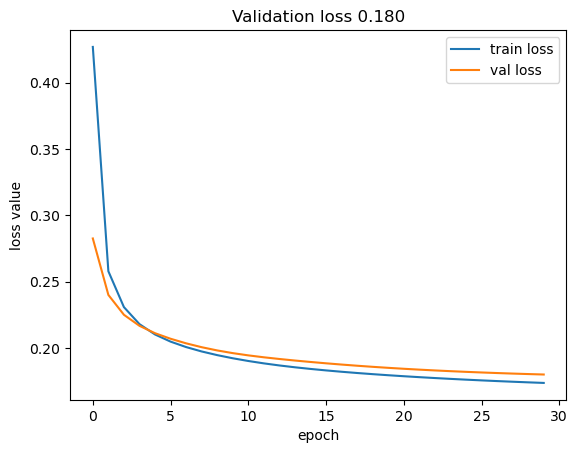

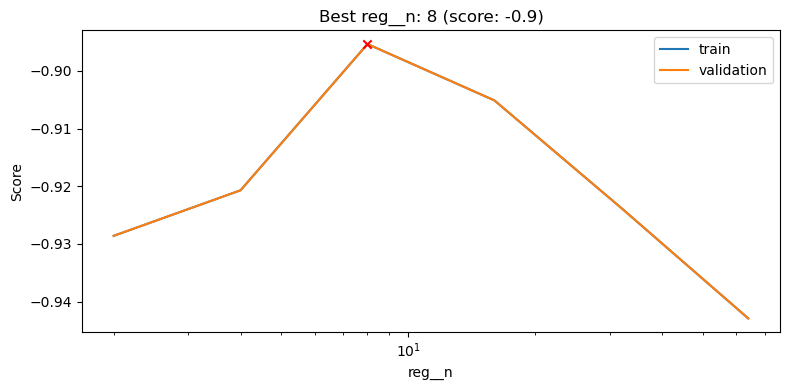

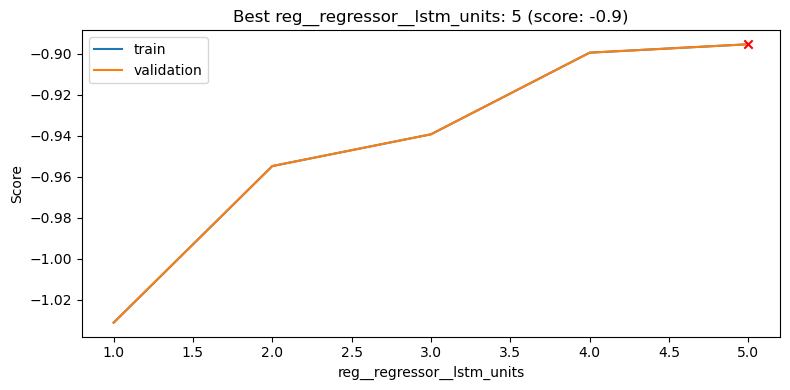

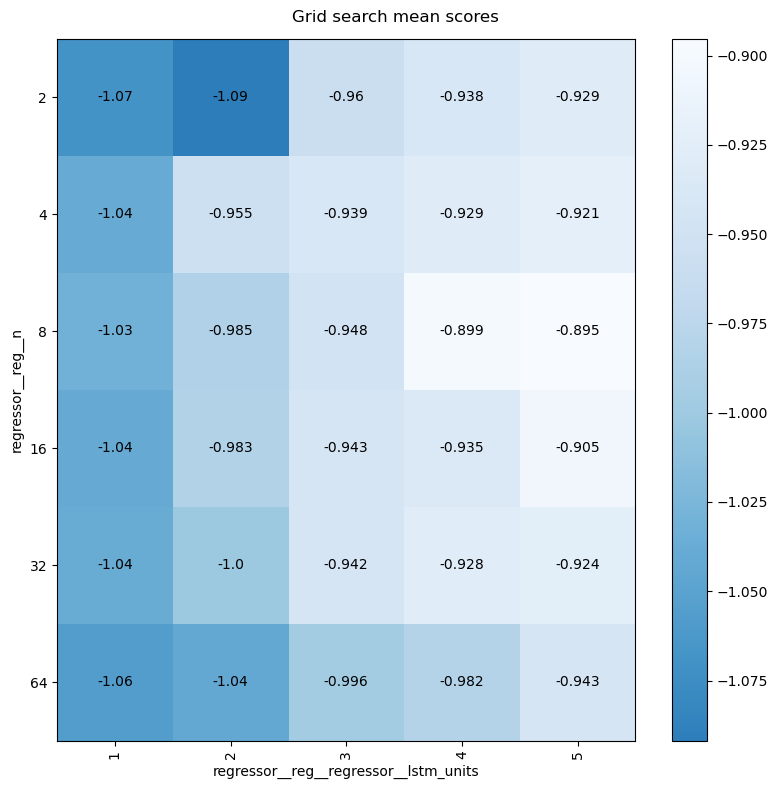

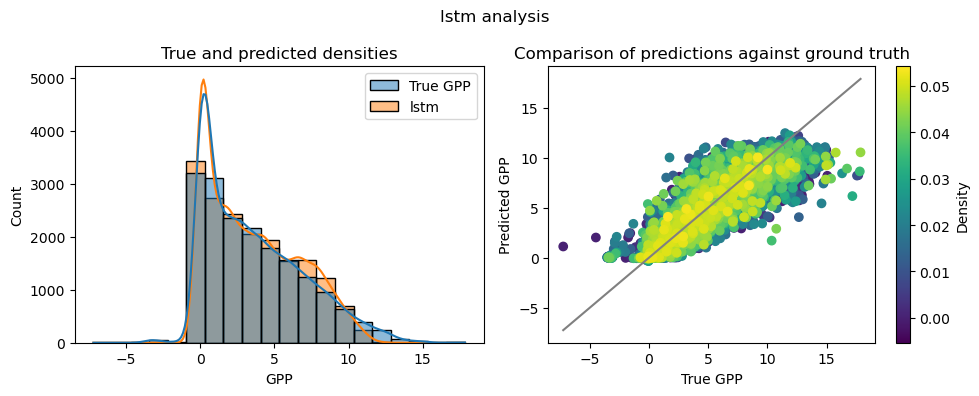

----
Predicting Test...
Prediction time: 0.22s
Score (Test): 0.83
MAE (Test): 1.01
RMSE (Test): 1.89


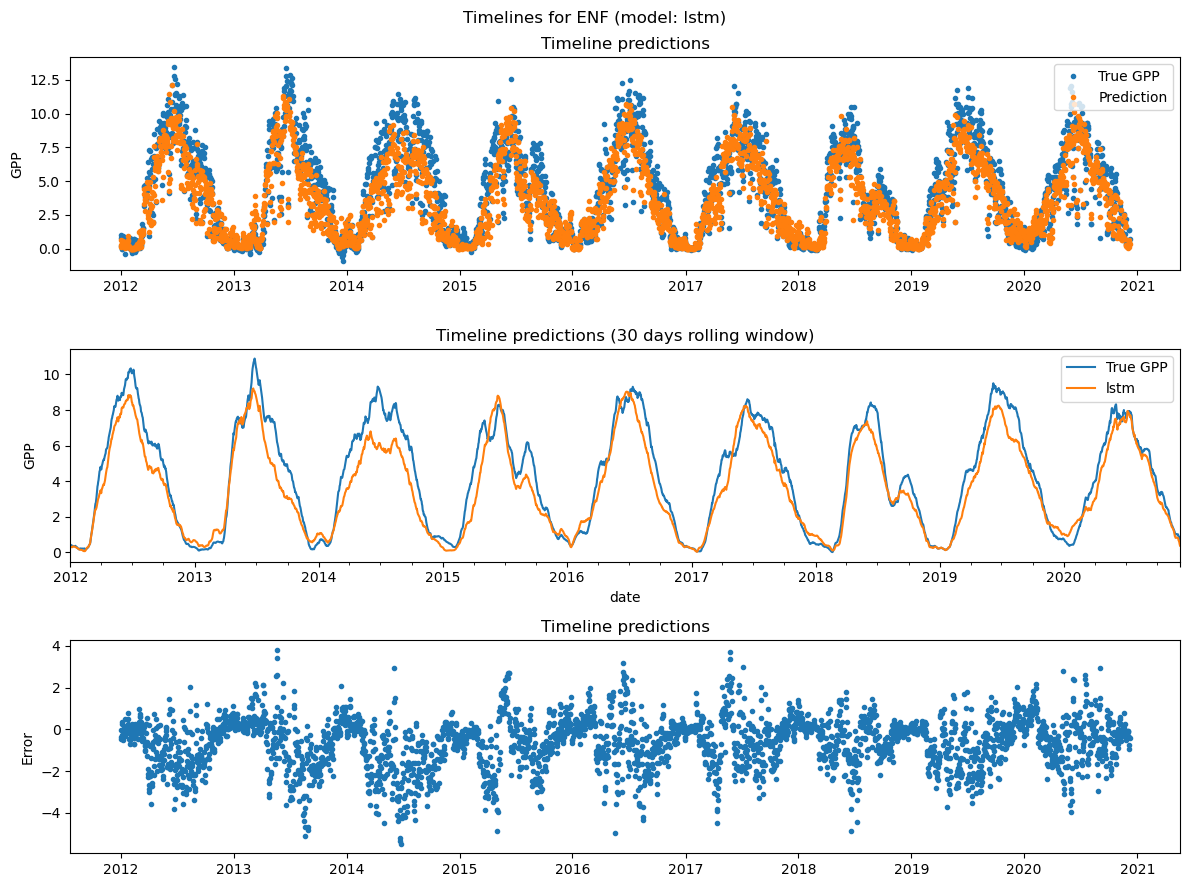

In [140]:
grid = make_grid(
    [
        QuantileTransformer(output_distribution="normal"),
    ],
    {
        "reg__window_size": [MAX_WINDOW],
        "reg__window_size": [2, 4, 8, 16, 32, 64],  # Total window size
        "reg__regressor__learning_rate": [0.001],
        "reg__regressor__lstm_units": [1, 2, 3, 4, 5],
        "reg__regressor__epochs": [30],
        "reg__regressor__verbose": [False],
    },
)

model, df_pred[name], pred_time, r2, mae, rmse = eval_model(
    None,
    build_model(),
    grid,
    X_tv,
    y_tv,
    X_test,
    y_test,
    verbose=2,
    n_splits=0,
    n_jobs=1,
)
plot_net_training_curves(model.best_estimator_.regressor_.named_steps.reg.regressor.history)
hyperparam_graph(model, "reg__window_size", xlog=True)
hyperparam_graph(model, "reg__regressor__lstm_units", xlog=False)
hyperparam_plot(model, ["reg__regressor__lstm_units", "reg__window_size"])
pred_plot(df_pred, name)
df_pred_test[name], _, _, _, _ = compute_metrics(
    model, df_test.drop(["GPP"], axis=1), df_pred_test["True GPP"], label="Test"
)
plot_timeline(df_pred_test, name, "ENF")
ding("LSTM")

#### n=4-32, l=4-10

Fitting 1 folds for each of 28 candidates, totalling 28 fits
[CV] END regressor__reg__n=4, regressor__reg__regressor__epochs=30, regressor__reg__regressor__learning_rate=0.001, regressor__reg__regressor__lstm_units=4, regressor__reg__regressor__verbose=False, regressor__scaler=QuantileTransformer(output_distribution='normal'), transformer=QuantileTransformer(output_distribution='normal'); total time= 2.5min
[CV] END regressor__reg__n=4, regressor__reg__regressor__epochs=30, regressor__reg__regressor__learning_rate=0.001, regressor__reg__regressor__lstm_units=5, regressor__reg__regressor__verbose=False, regressor__scaler=QuantileTransformer(output_distribution='normal'), transformer=QuantileTransformer(output_distribution='normal'); total time= 2.5min
[CV] END regressor__reg__n=4, regressor__reg__regressor__epochs=30, regressor__reg__regressor__learning_rate=0.001, regressor__reg__regressor__lstm_units=6, regressor__reg__regressor__verbose=False, regressor__scaler=QuantileTransformer(ou

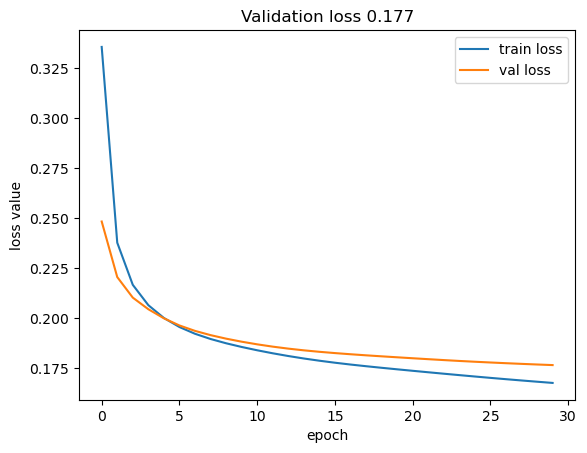

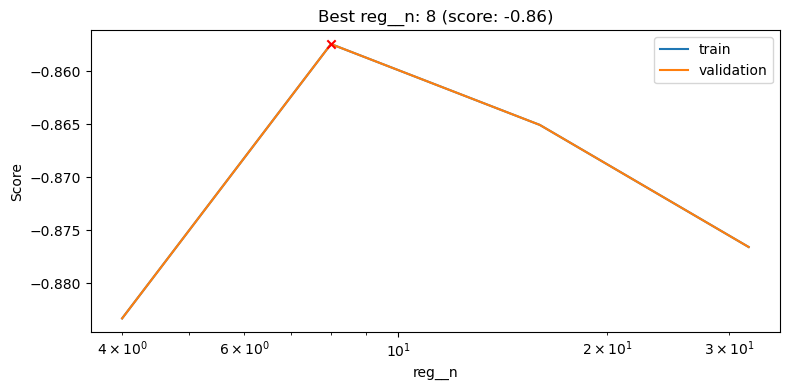

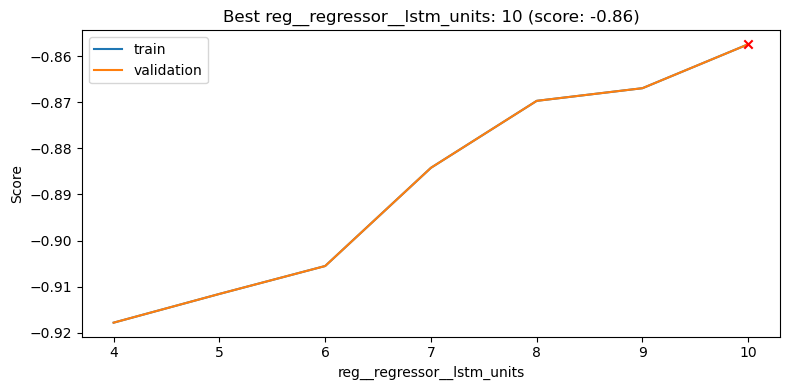

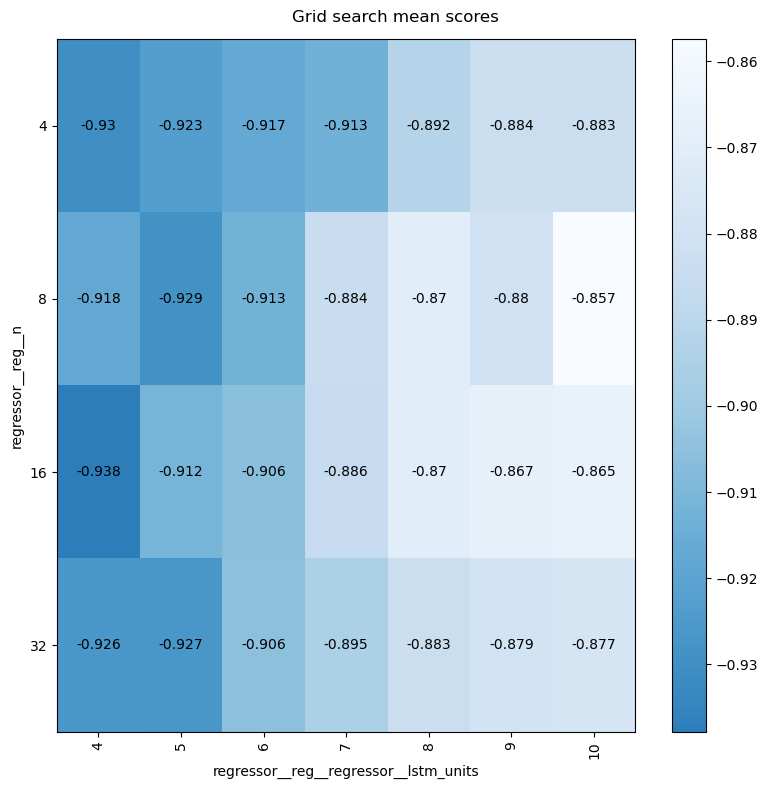

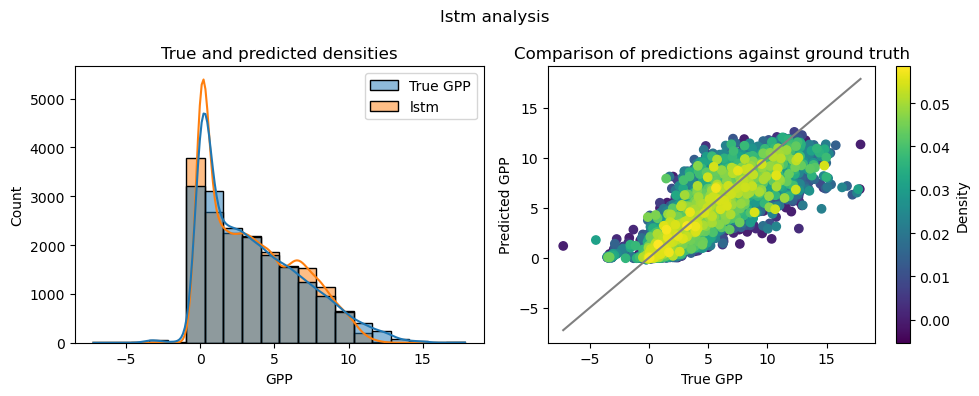

----
Predicting Test...
Prediction time: 0.22s
Score (Test): 0.84
MAE (Test): 0.96
RMSE (Test): 1.72


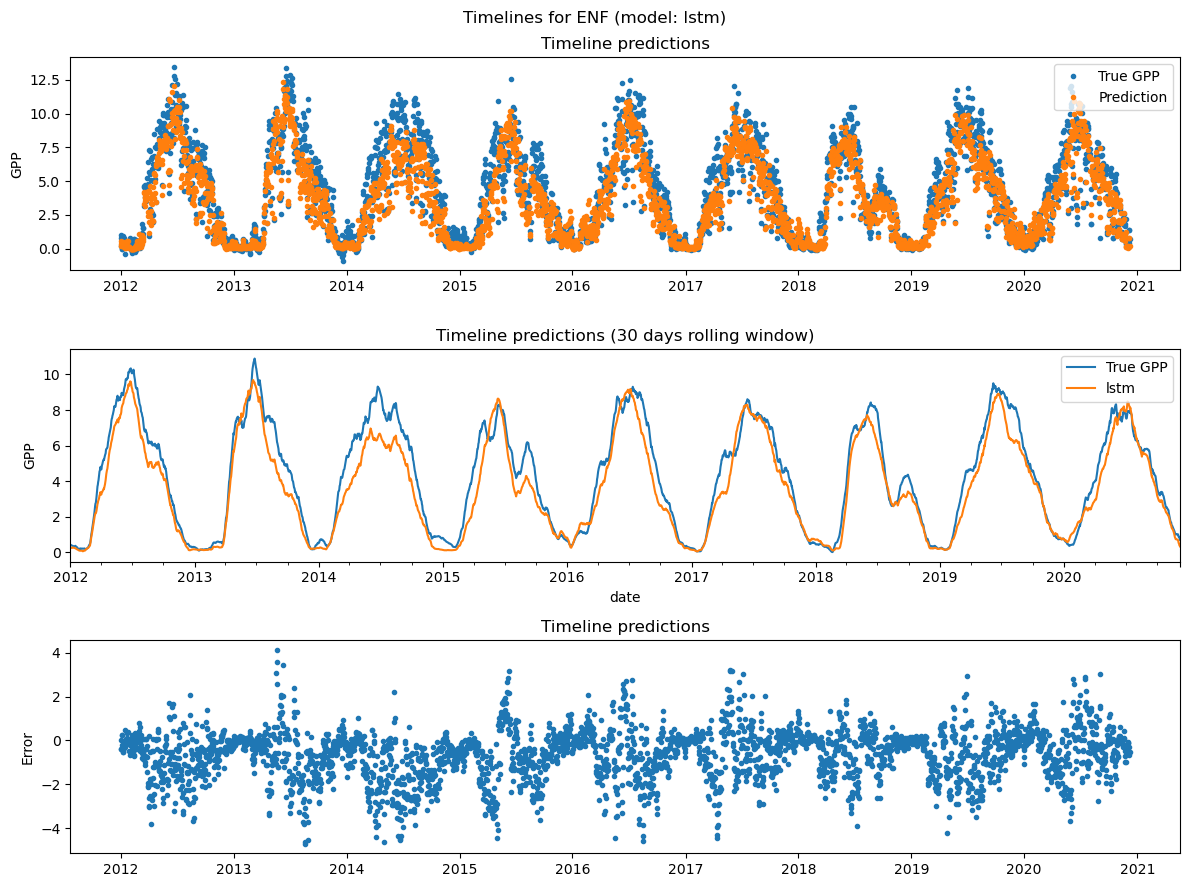

In [141]:
grid = make_grid(
    [
        QuantileTransformer(output_distribution="normal"),
    ],
    {
        "reg__window_size": [MAX_WINDOW],
        "reg__window_size": [4, 8, 16, 32],  # Total window size
        "reg__regressor__learning_rate": [0.001],
        "reg__regressor__lstm_units": [4, 5, 6, 7, 8, 9, 10],
        "reg__regressor__epochs": [30],
        "reg__regressor__verbose": [False],
    },
)

model, df_pred[name], pred_time, r2, mae, rmse = eval_model(
    None,
    build_model(),
    grid,
    X_tv,
    y_tv,
    X_test,
    y_test,
    verbose=2,
    n_splits=0,
    n_jobs=1,
)
plot_net_training_curves(model.best_estimator_.regressor_.named_steps.reg.regressor.history)
hyperparam_graph(model, "reg__window_size", xlog=True)
hyperparam_graph(model, "reg__regressor__lstm_units", xlog=False)
hyperparam_plot(model, ["reg__regressor__lstm_units", "reg__window_size"])
pred_plot(df_pred, name)
df_pred_test[name], _, _, _, _ = compute_metrics(
    model, df_test.drop(["GPP"], axis=1), df_pred_test["True GPP"], label="Test"
)
plot_timeline(df_pred_test, name, "ENF")
ding("LSTM")

#### n=8-64, l=10-20

Fitting 1 folds for each of 24 candidates, totalling 24 fits
[CV] END regressor__reg__n=8, regressor__reg__regressor__epochs=30, regressor__reg__regressor__learning_rate=0.001, regressor__reg__regressor__lstm_units=10, regressor__reg__regressor__verbose=False, regressor__scaler=QuantileTransformer(output_distribution='normal'), transformer=QuantileTransformer(output_distribution='normal'); total time= 1.8min
[CV] END regressor__reg__n=8, regressor__reg__regressor__epochs=30, regressor__reg__regressor__learning_rate=0.001, regressor__reg__regressor__lstm_units=12, regressor__reg__regressor__verbose=False, regressor__scaler=QuantileTransformer(output_distribution='normal'), transformer=QuantileTransformer(output_distribution='normal'); total time= 1.9min
[CV] END regressor__reg__n=8, regressor__reg__regressor__epochs=30, regressor__reg__regressor__learning_rate=0.001, regressor__reg__regressor__lstm_units=14, regressor__reg__regressor__verbose=False, regressor__scaler=QuantileTransformer

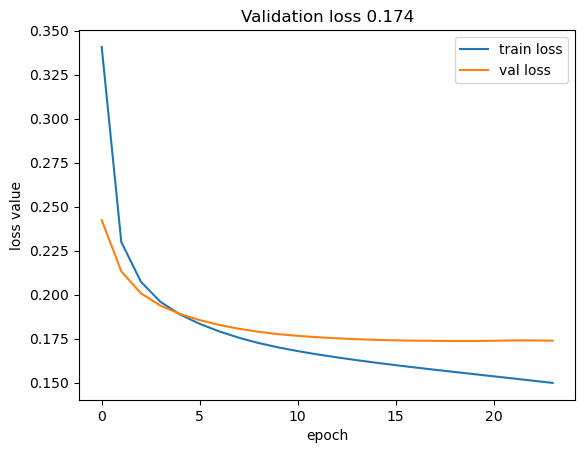

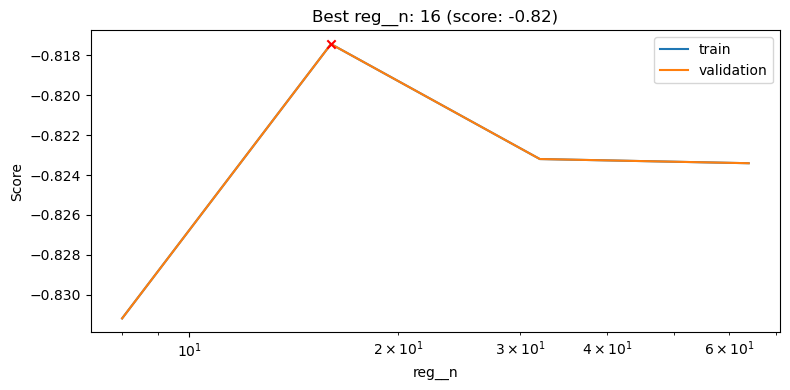

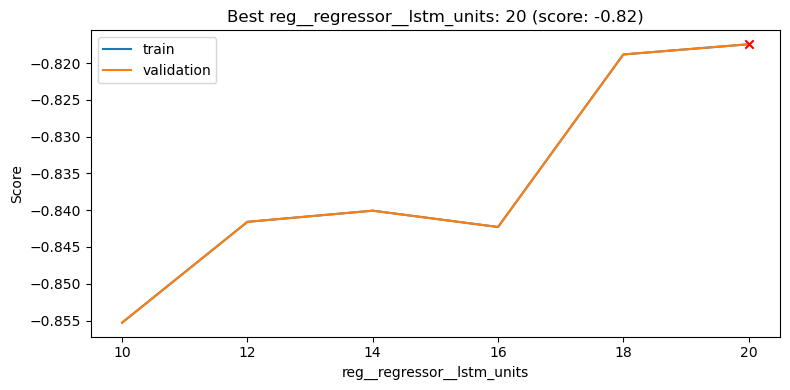

Deploy FastAPI apps for free on Ploomber Cloud! Learn more: https://ploomber.io/s/signup


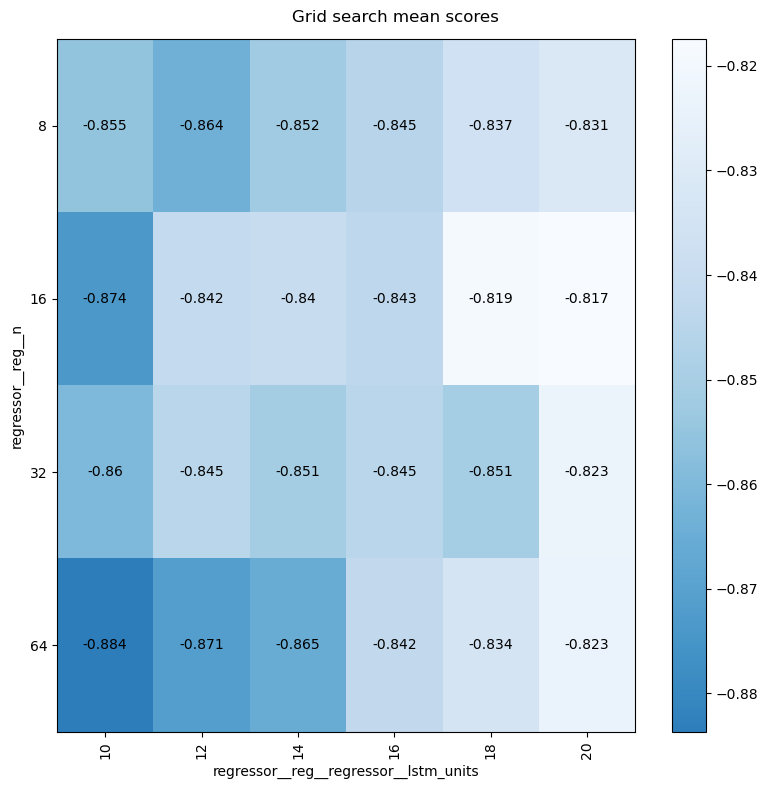

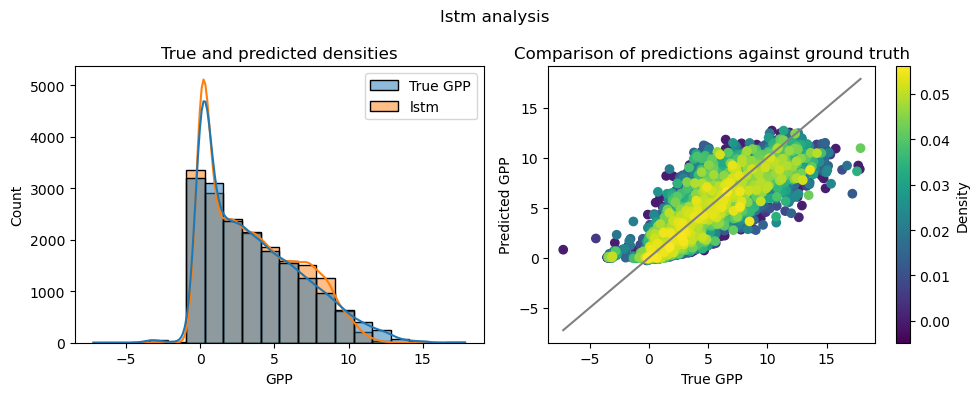

----
Predicting Test...
Prediction time: 0.23s
Score (Test): 0.83
MAE (Test): 0.97
RMSE (Test): 1.82


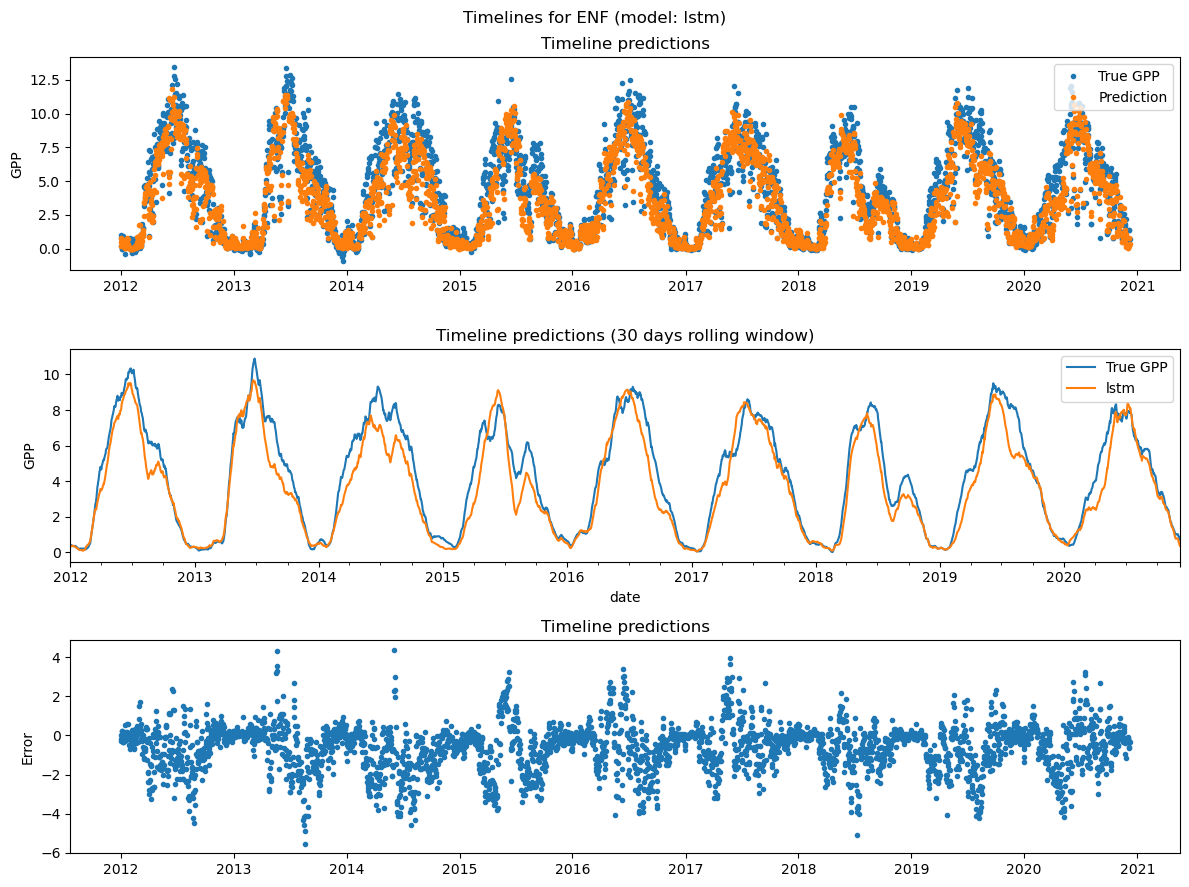

In [144]:
grid = make_grid(
    [
        QuantileTransformer(output_distribution="normal"),
    ],
    {
        "reg__window_size": [MAX_WINDOW],
        "reg__window_size": [8, 16, 32, 64],  # Total window size
        # "reg__shuffle": [True],
        "reg__regressor__learning_rate": [0.001],
        "reg__regressor__lstm_units": [10, 12, 14, 16, 18, 20],
        "reg__regressor__epochs": [30],
        "reg__regressor__verbose": [False],
    },
)

model, df_pred[name], pred_time, r2, mae, rmse = eval_model(
    None,
    build_model(),
    grid,
    X_tv,
    y_tv,
    X_test,
    y_test,
    verbose=2,
    n_splits=0,
    n_jobs=1,
)
plot_net_training_curves(model.best_estimator_.regressor_.named_steps.reg.regressor.history)
hyperparam_graph(model, "reg__window_size", xlog=True)
hyperparam_graph(model, "reg__regressor__lstm_units", xlog=False)
hyperparam_plot(model, ["reg__regressor__lstm_units", "reg__window_size"])
pred_plot(df_pred, name)
df_pred_test[name], _, _, _, _ = compute_metrics(
    model, df_test.drop(["GPP"], axis=1), df_pred_test["True GPP"], label="Test"
)
plot_timeline(df_pred_test, name, "ENF")
ding("LSTM")

#### n=8-32, l=20-50

Fitting 1 folds for each of 21 candidates, totalling 21 fits
[CV] END regressor__reg__n=8, regressor__reg__regressor__epochs=30, regressor__reg__regressor__learning_rate=0.001, regressor__reg__regressor__lstm_units=20, regressor__reg__regressor__verbose=False, regressor__scaler=QuantileTransformer(output_distribution='normal'), transformer=QuantileTransformer(output_distribution='normal'); total time= 1.9min
[CV] END regressor__reg__n=8, regressor__reg__regressor__epochs=30, regressor__reg__regressor__learning_rate=0.001, regressor__reg__regressor__lstm_units=25, regressor__reg__regressor__verbose=False, regressor__scaler=QuantileTransformer(output_distribution='normal'), transformer=QuantileTransformer(output_distribution='normal'); total time= 1.9min
[CV] END regressor__reg__n=8, regressor__reg__regressor__epochs=30, regressor__reg__regressor__learning_rate=0.001, regressor__reg__regressor__lstm_units=30, regressor__reg__regressor__verbose=False, regressor__scaler=QuantileTransformer

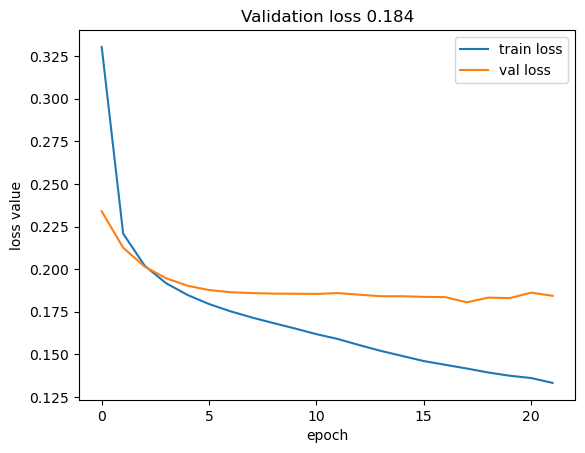

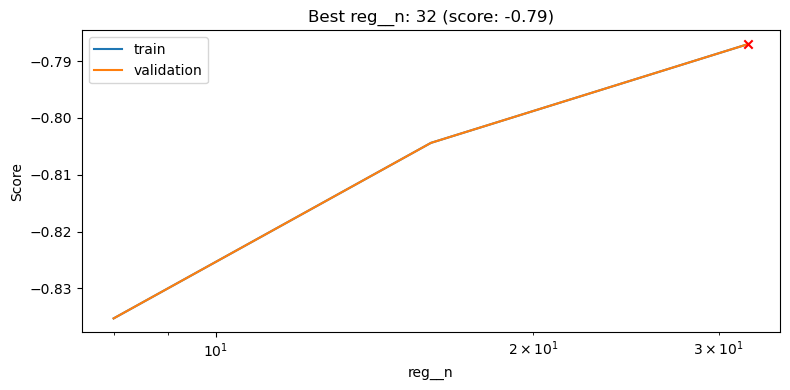

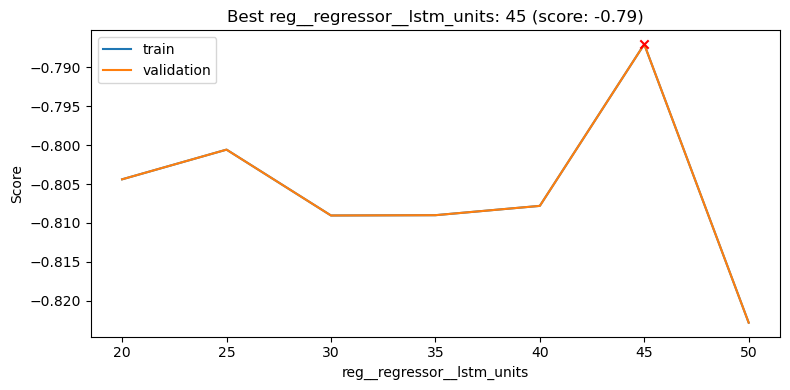

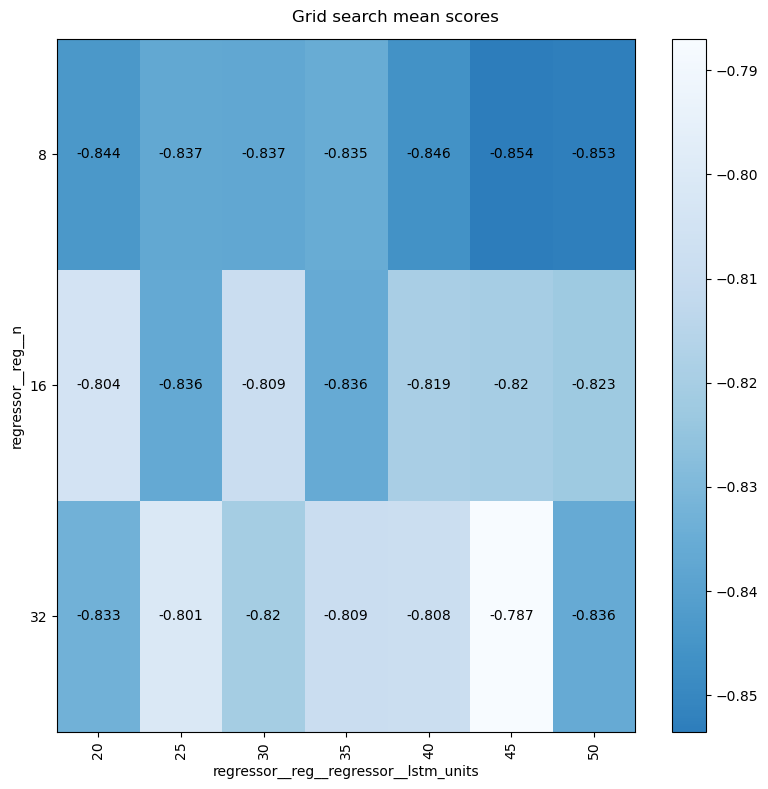

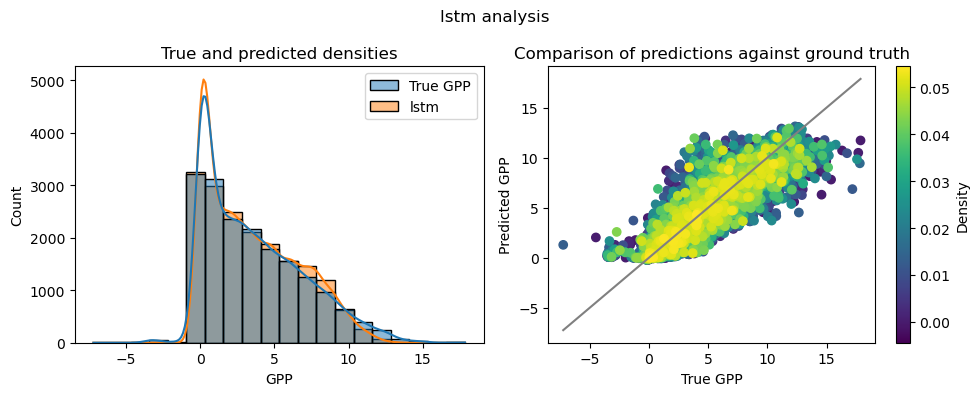

----
Predicting Test...
Prediction time: 0.27s
Score (Test): 0.8
MAE (Test): 1.05
RMSE (Test): 2.23


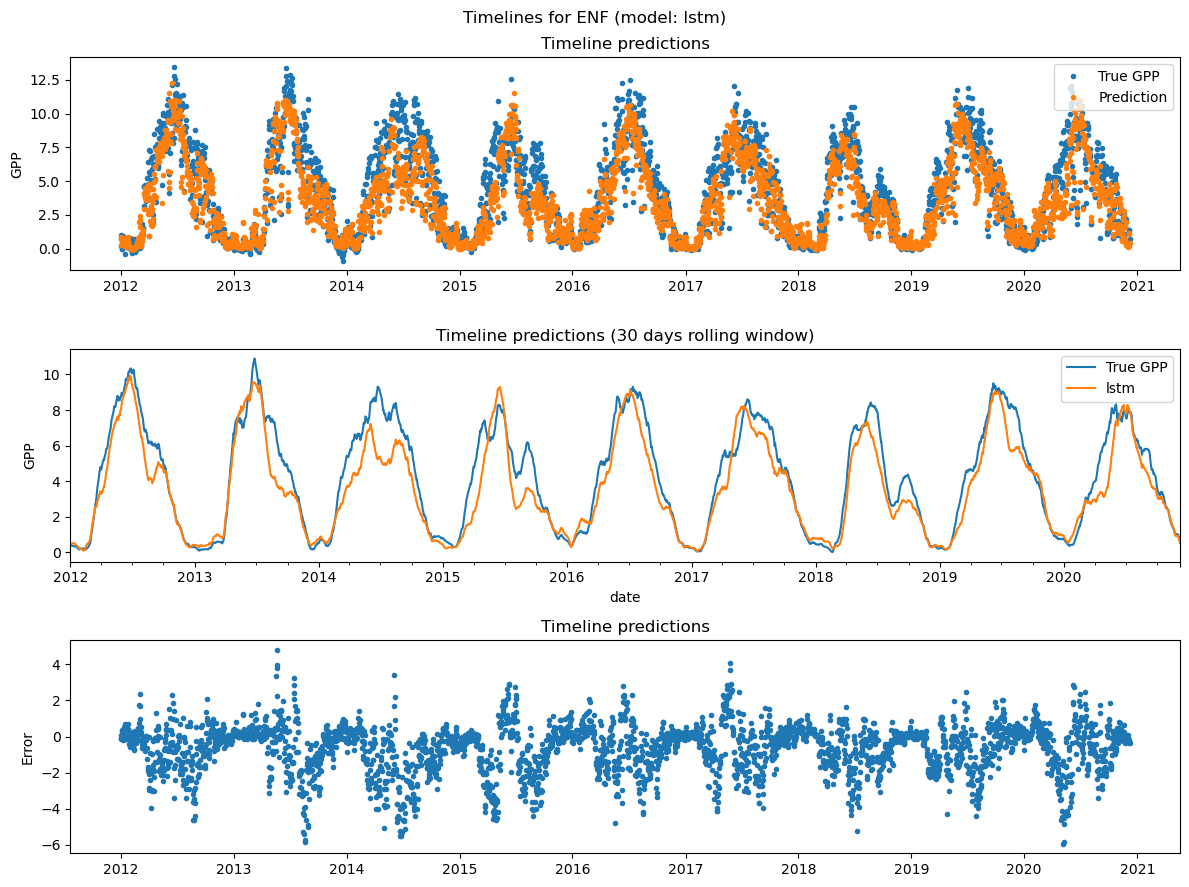

In [145]:
grid = make_grid(
    [
        QuantileTransformer(output_distribution="normal"),
    ],
    {
        "reg__window_size": [MAX_WINDOW],
        "reg__window_size": [8, 16, 32],  # Total window size
        # "reg__shuffle": [True],
        "reg__regressor__learning_rate": [0.001],
        "reg__regressor__lstm_units": [20, 25, 30, 35, 40, 45, 50],
        "reg__regressor__epochs": [30],
        "reg__regressor__verbose": [False],
    },
)

model, df_pred[name], pred_time, r2, mae, rmse = eval_model(
    None,
    build_model(),
    grid,
    X_tv,
    y_tv,
    X_test,
    y_test,
    verbose=2,
    n_splits=0,
    n_jobs=1,
)
plot_net_training_curves(model.best_estimator_.regressor_.named_steps.reg.regressor.history)
hyperparam_graph(model, "reg__window_size", xlog=True)
hyperparam_graph(model, "reg__regressor__lstm_units", xlog=False)
hyperparam_plot(model, ["reg__regressor__lstm_units", "reg__window_size"])
pred_plot(df_pred, name)
df_pred_test[name], _, _, _, _ = compute_metrics(
    model, df_test.drop(["GPP"], axis=1), df_pred_test["True GPP"], label="Test"
)
plot_timeline(df_pred_test, name, "ENF")
ding("LSTM")

#### batch=1-64

Fitting 1 folds for each of 7 candidates, totalling 7 fits
[CV] END regressor__reg__batch_size=1, regressor__reg__n=8, regressor__reg__regressor__epochs=30, regressor__reg__regressor__learning_rate=0.001, regressor__reg__regressor__lstm_units=5, regressor__reg__regressor__verbose=False, regressor__scaler=QuantileTransformer(output_distribution='normal'), transformer=QuantileTransformer(output_distribution='normal'); total time=14.3min
[CV] END regressor__reg__batch_size=2, regressor__reg__n=8, regressor__reg__regressor__epochs=30, regressor__reg__regressor__learning_rate=0.001, regressor__reg__regressor__lstm_units=5, regressor__reg__regressor__verbose=False, regressor__scaler=QuantileTransformer(output_distribution='normal'), transformer=QuantileTransformer(output_distribution='normal'); total time= 7.3min
[CV] END regressor__reg__batch_size=4, regressor__reg__n=8, regressor__reg__regressor__epochs=30, regressor__reg__regressor__learning_rate=0.001, regressor__reg__regressor__lstm_uni

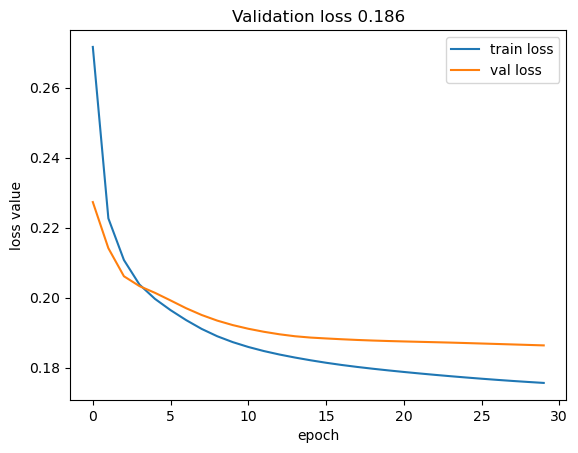

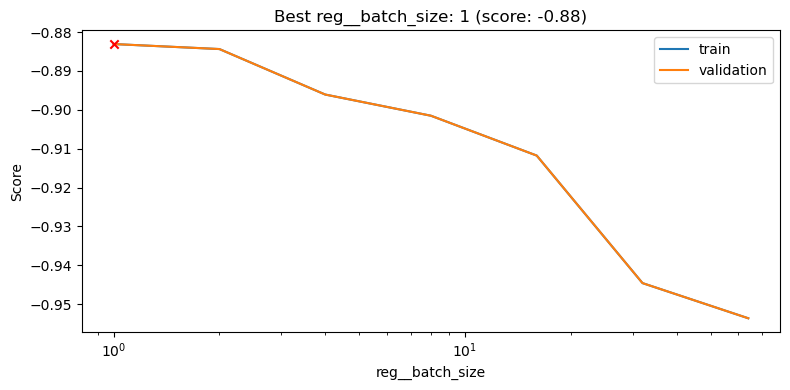

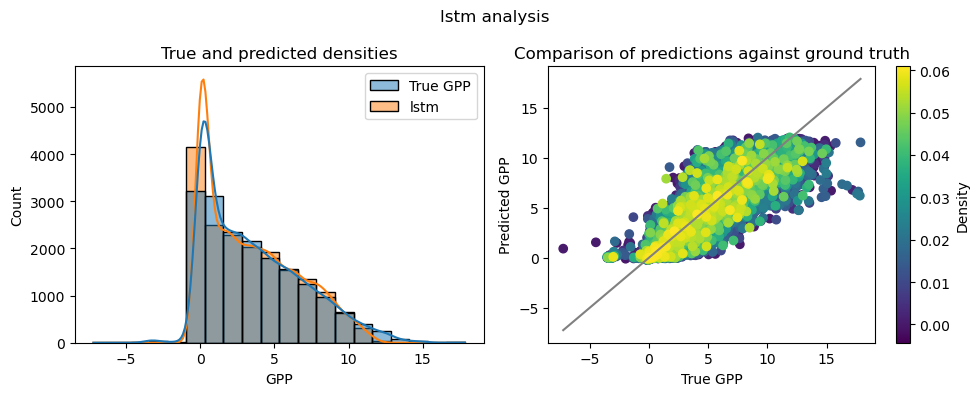

----
Predicting Test...
Prediction time: 0.33s
Score (Test): 0.85
MAE (Test): 0.96
RMSE (Test): 1.68


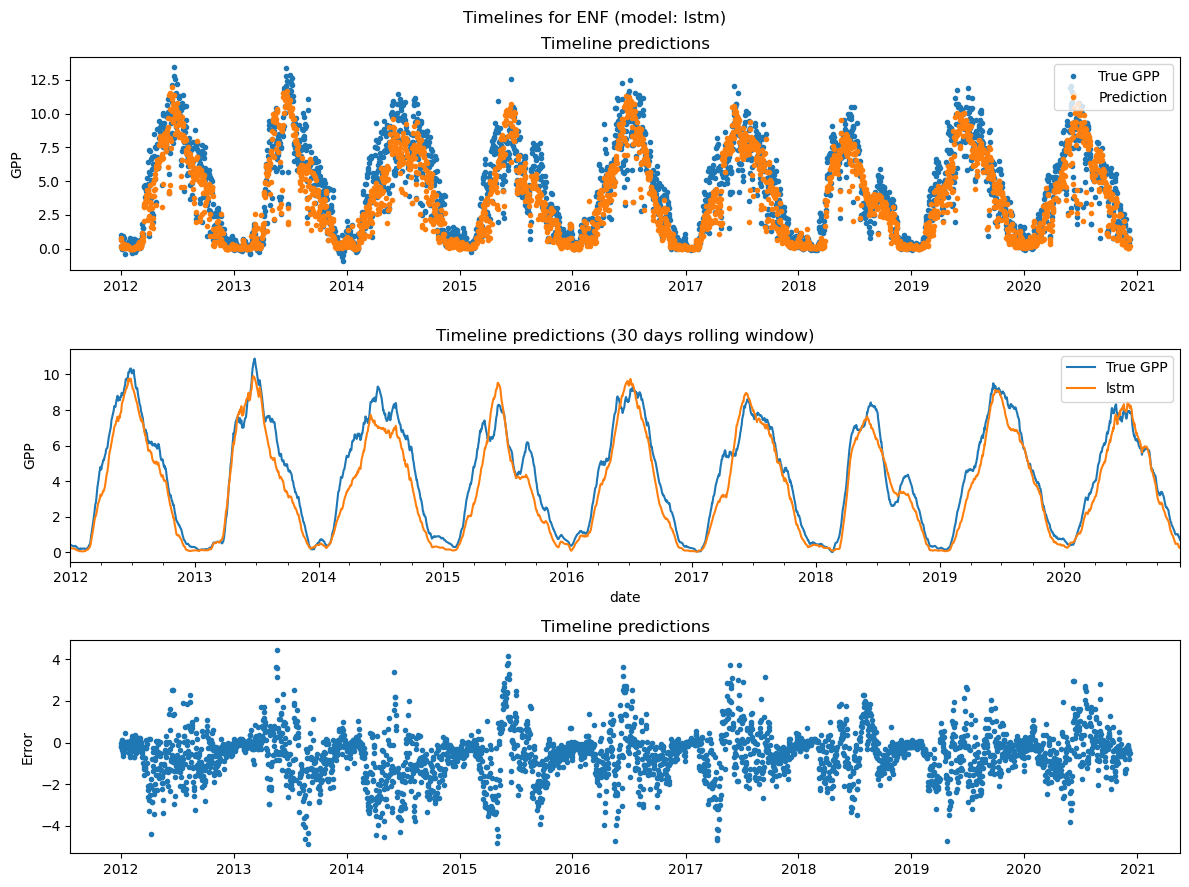

In [147]:
grid = make_grid(
    [
        QuantileTransformer(output_distribution="normal"),
    ],
    {
        "reg__window_size": [MAX_WINDOW],
        "reg__window_size": [8],  # Total window size
        # "reg__shuffle": [True],
        "reg__regressor__learning_rate": [0.001],
        "reg__regressor__lstm_units": [5],
        "reg__regressor__epochs": [30],
        "reg__regressor__verbose": [False],
        "reg__batch_size": [1, 2, 4, 8, 16, 32, 64],
    },
)

model, df_pred[name], pred_time, r2, mae, rmse = eval_model(
    None,
    build_model(),
    grid,
    X_tv,
    y_tv,
    X_test,
    y_test,
    verbose=2,
    n_splits=0,
    n_jobs=1,
)
plot_net_training_curves(model.best_estimator_.regressor_.named_steps.reg.regressor.history)
hyperparam_graph(model, "reg__batch_size", xlog=True)
# hyperparam_graph(model, "reg__regressor__lstm_units", xlog=False)
# hyperparam_plot(model, ["reg__regressor__lstm_units", "reg__window_size"])
pred_plot(df_pred, name)
df_pred_test[name], _, _, _, _ = compute_metrics(
    model, df_test.drop(["GPP"], axis=1), df_pred_test["True GPP"], label="Test"
)
plot_timeline(df_pred_test, name, "ENF")
ding("LSTM")

#### n=8, l=5, regularizers

Fitting 1 folds for each of 16 candidates, totalling 16 fits
[CV] END regressor__reg__batch_size=8, regressor__reg__n=8, regressor__reg__regressor__epochs=30, regressor__reg__regressor__kernel_regularizer=0, regressor__reg__regressor__learning_rate=0.001, regressor__reg__regressor__lstm_units=5, regressor__reg__regressor__recurrent_regularizer=0, regressor__reg__regressor__verbose=False, regressor__scaler=QuantileTransformer(output_distribution='normal'), transformer=QuantileTransformer(output_distribution='normal'); total time= 1.8min
[CV] END regressor__reg__batch_size=8, regressor__reg__n=8, regressor__reg__regressor__epochs=30, regressor__reg__regressor__kernel_regularizer=0, regressor__reg__regressor__learning_rate=0.001, regressor__reg__regressor__lstm_units=5, regressor__reg__regressor__recurrent_regularizer=0.001, regressor__reg__regressor__verbose=False, regressor__scaler=QuantileTransformer(output_distribution='normal'), transformer=QuantileTransformer(output_distribution='no

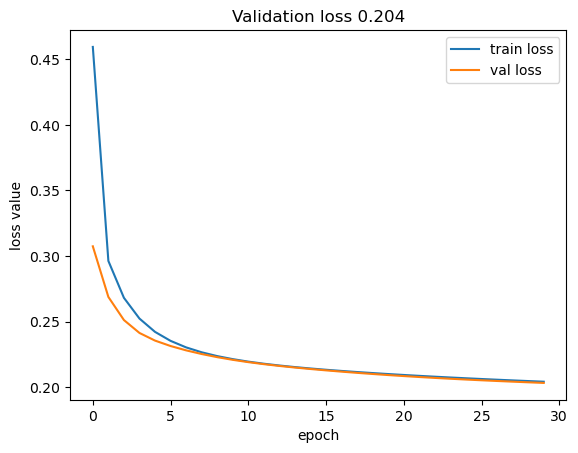

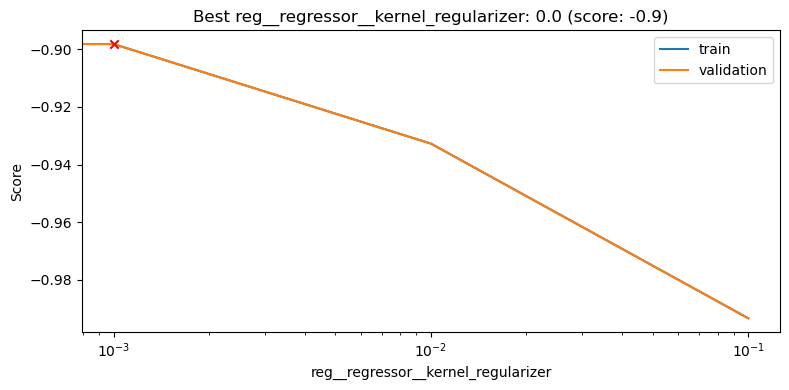

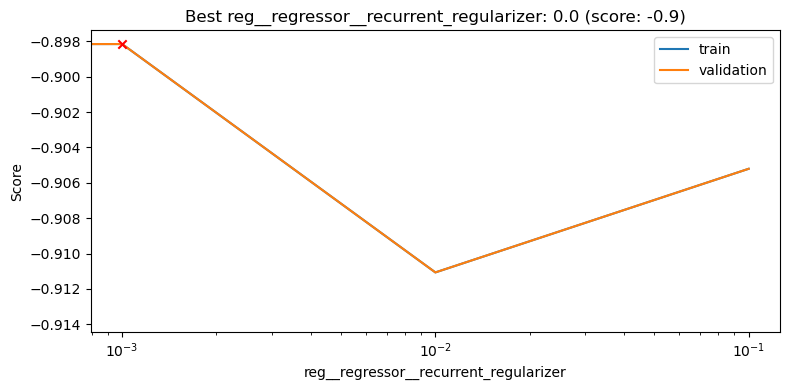

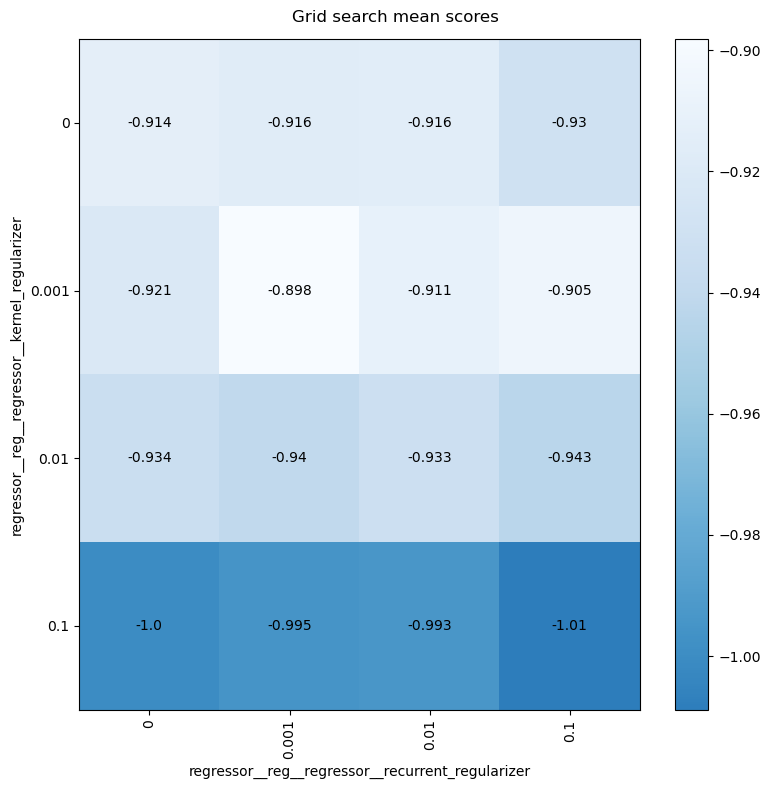

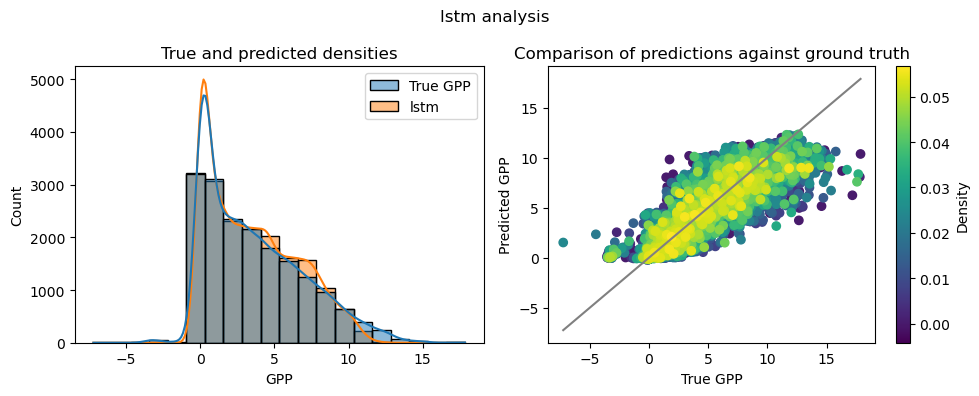

----
Predicting Test...
Prediction time: 0.23s
Score (Test): 0.81
MAE (Test): 1.06
RMSE (Test): 2.1


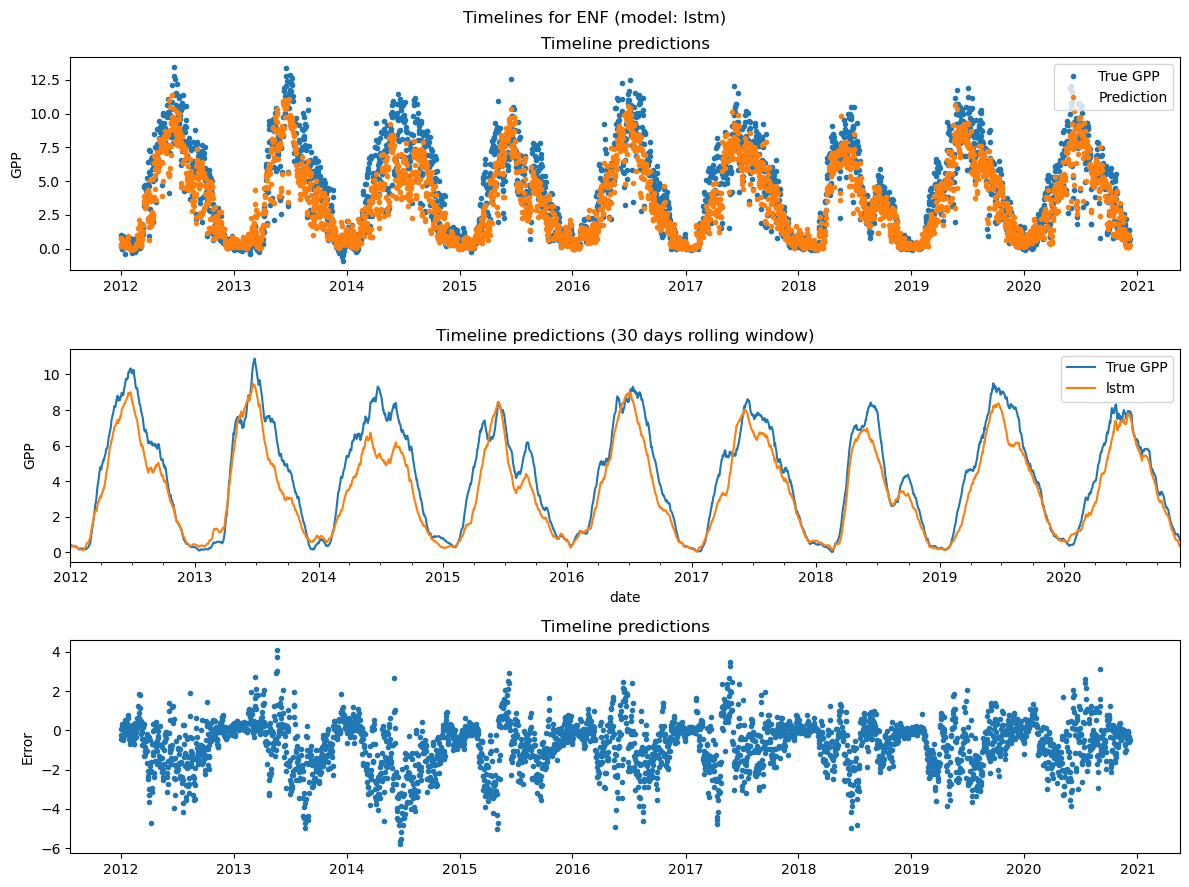

In [151]:
grid = make_grid(
    [
        QuantileTransformer(output_distribution="normal"),
    ],
    {
        "reg__window_size": [MAX_WINDOW],
        "reg__window_size": [8],  # Total window size
        # "reg__shuffle": [True],
        "reg__regressor__learning_rate": [0.001],
        "reg__regressor__lstm_units": [5],
        "reg__regressor__epochs": [30],
        "reg__regressor__verbose": [False],
        "reg__regressor__recurrent_regularizer": [0, 0.001, 0.01, 0.1],
        "reg__regressor__kernel_regularizer": [0, 0.001, 0.01, 0.1],
        "reg__batch_size": [8],
    },
)

model, df_pred[name], pred_time, r2, mae, rmse = eval_model(
    None,
    build_model(),
    grid,
    X_tv,
    y_tv,
    X_test,
    y_test,
    verbose=2,
    n_splits=0,
    n_jobs=1,
)
plot_net_training_curves(model.best_estimator_.regressor_.named_steps.reg.regressor.history)
hyperparam_graph(model, "reg__regressor__kernel_regularizer", xlog=True)
hyperparam_graph(model, "reg__regressor__recurrent_regularizer", xlog=True)
hyperparam_plot(
    model,
    ["reg__regressor__recurrent_regularizer", "reg__regressor__kernel_regularizer"],
)
pred_plot(df_pred, name)
df_pred_test[name], _, _, _, _ = compute_metrics(
    model, df_test.drop(["GPP"], axis=1), df_pred_test["True GPP"], label="Test"
)
plot_timeline(df_pred_test, name, "ENF")
ding("LSTM")

## 2 layers

In [193]:
def model_fun(
    lstm_units,
    lstm_units2,
    learning_rate,
    dropout=0,
    recurrent_dropout=0,
    kernel_regularizer=0,
    recurrent_regularizer=0,
    seed=0,
):
    model = tf.keras.models.Sequential(
        [
            # Shape [batch, time, features] => [batch, time, lstm_units]
            tf.keras.layers.LSTM(
                lstm_units,
                return_sequences=True,
                dropout=dropout,
                recurrent_dropout=recurrent_dropout,
                kernel_regularizer=tf.keras.regularizers.L2(kernel_regularizer),
                recurrent_regularizer=tf.keras.regularizers.L2(recurrent_regularizer),
                # seed=seed
            ),
            tf.keras.layers.LSTM(
                lstm_units2,
                return_sequences=True,
                dropout=dropout,
                recurrent_dropout=recurrent_dropout,
                kernel_regularizer=tf.keras.regularizers.L2(kernel_regularizer),
                recurrent_regularizer=tf.keras.regularizers.L2(recurrent_regularizer),
                # seed=seed
            ),
            # Shape => [batch, time, features]
            tf.keras.layers.Dense(units=1),
        ]
    )
    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        metrics=[tf.keras.metrics.MeanAbsoluteError()],
    )
    # model.summary()
    return model

In [194]:
def build_model():
    regressor = WindowRegressor(
        HistoryKerasRegressor(
            model_fun,
            verbose=1,
            shuffle=False,
            epochs=100,
            callbacks=[keras.callbacks.EarlyStopping(patience=4, mode="min")],
        ),
        window_size=1,
    )
    return regressor

#### 32/16

Fitting 1 folds for each of 1 candidates, totalling 1 fits
Epoch 1/50
112/112 [==============================] - 9s 45ms/step - loss: 0.3954 - mean_absolute_error: 0.4628 - val_loss: 0.3028 - val_mean_absolute_error: 0.3920
Epoch 2/50
112/112 [==============================] - 4s 39ms/step - loss: 0.2870 - mean_absolute_error: 0.3795 - val_loss: 0.2703 - val_mean_absolute_error: 0.3633
Epoch 3/50
112/112 [==============================] - 5s 41ms/step - loss: 0.2628 - mean_absolute_error: 0.3598 - val_loss: 0.2544 - val_mean_absolute_error: 0.3506
Epoch 4/50
112/112 [==============================] - 5s 40ms/step - loss: 0.2476 - mean_absolute_error: 0.3470 - val_loss: 0.2440 - val_mean_absolute_error: 0.3421
Epoch 5/50
112/112 [==============================] - 5s 42ms/step - loss: 0.2356 - mean_absolute_error: 0.3368 - val_loss: 0.2361 - val_mean_absolute_error: 0.3356
Epoch 6/50
112/112 [==============================] - 4s 40ms/step - loss: 0.2253 - mean_absolute_error: 0.3278 - va

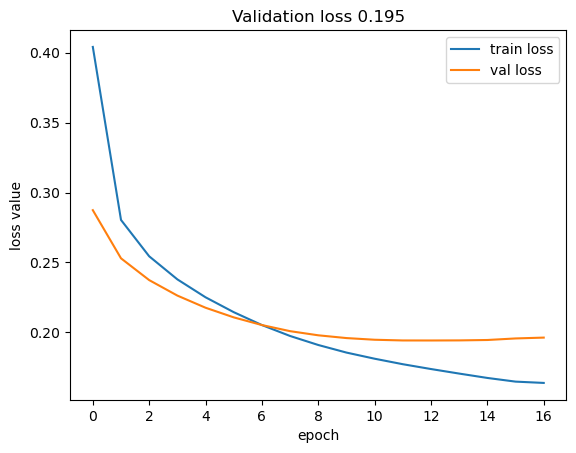

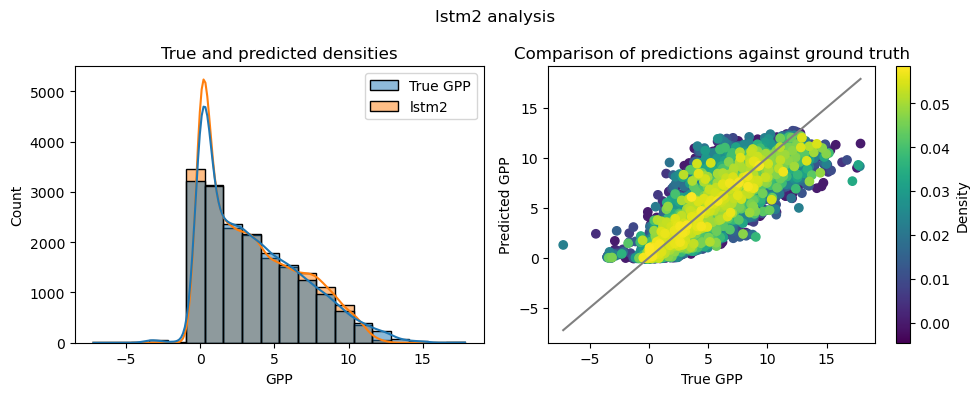

----
Predicting Test...
7/7 [==============================] - 0s 9ms/step
Prediction time: 0.94s
Score (Test): 0.83
MAE (Test): 0.99
RMSE (Test): 1.91


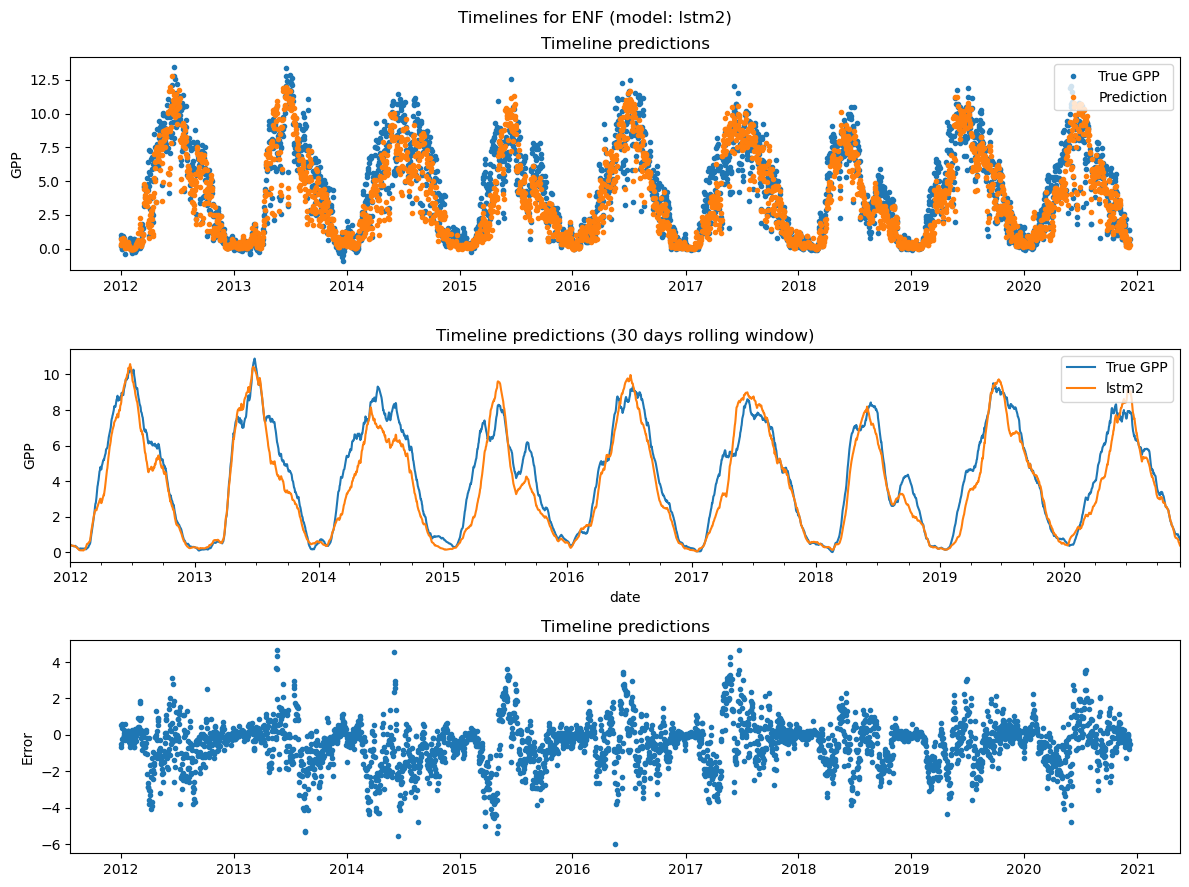

In [159]:
name = "lstm2"

grid = make_grid(
    [
        QuantileTransformer(output_distribution="normal"),
    ],
    {
        "reg__window_size": [MAX_WINDOW],
        "reg__window_size": [64],  # Total window size
        "reg__regressor__learning_rate": [0.001],
        "reg__regressor__lstm_units": [32],
        "reg__regressor__lstm_units2": [16],
        "reg__regressor__recurrent_regularizer": [0.0001],
        "reg__regressor__kernel_regularizer": [0.0001],
        "reg__regressor__epochs": [50],
    },
)

model, df_pred[name], pred_time, r2, mae, rmse = eval_model(
    None,
    build_model(),
    grid,
    X_tv,
    y_tv,
    X_test,
    y_test,
    verbose=2,
    n_splits=0,
    n_jobs=1,
)
plot_net_training_curves(model.best_estimator_.regressor_.named_steps.reg.regressor.history)
# plot_timeline(df_pred, name, "ENF")
pred_plot(df_pred, name)
df_pred_test[name], _, _, _, _ = compute_metrics(
    model, df_test.drop(["GPP"], axis=1), df_pred_test["True GPP"], label="Test"
)
plot_timeline(df_pred_test, name, "ENF")

#### 4/4

Fitting 1 folds for each of 16 candidates, totalling 16 fits
Epoch 1/100
1782/1782 [==============================] - 13s 5ms/step - loss: 0.5053 - mean_absolute_error: 0.5318 - val_loss: 0.3216 - val_mean_absolute_error: 0.4186
Epoch 2/100
1782/1782 [==============================] - 9s 5ms/step - loss: 0.2750 - mean_absolute_error: 0.3792 - val_loss: 0.2431 - val_mean_absolute_error: 0.3593
Epoch 3/100
1782/1782 [==============================] - 9s 5ms/step - loss: 0.2415 - mean_absolute_error: 0.3514 - val_loss: 0.2288 - val_mean_absolute_error: 0.3454
Epoch 4/100
1782/1782 [==============================] - 9s 5ms/step - loss: 0.2313 - mean_absolute_error: 0.3422 - val_loss: 0.2224 - val_mean_absolute_error: 0.3393
Epoch 5/100
1782/1782 [==============================] - 9s 5ms/step - loss: 0.2253 - mean_absolute_error: 0.3369 - val_loss: 0.2187 - val_mean_absolute_error: 0.3357
Epoch 6/100
1782/1782 [==============================] - 9s 5ms/step - loss: 0.2204 - mean_absolute_err

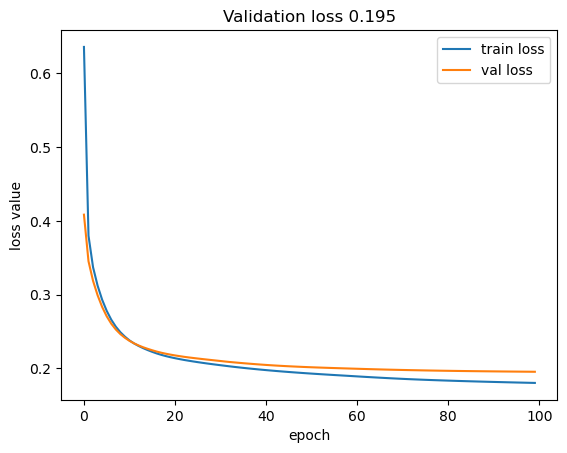

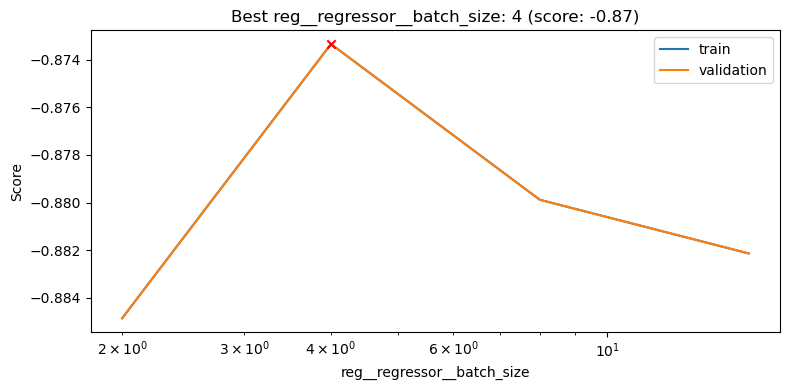

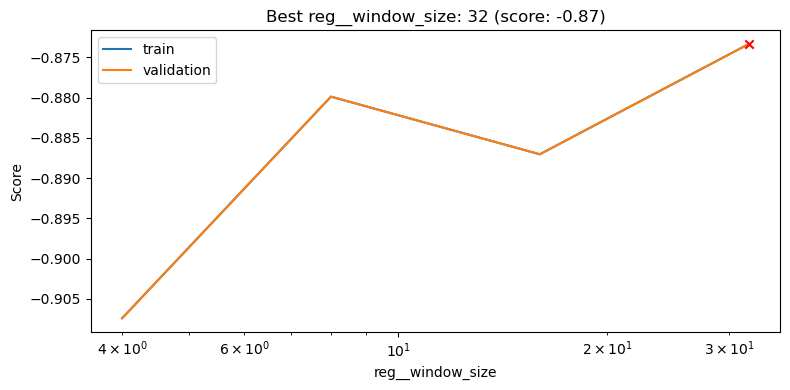

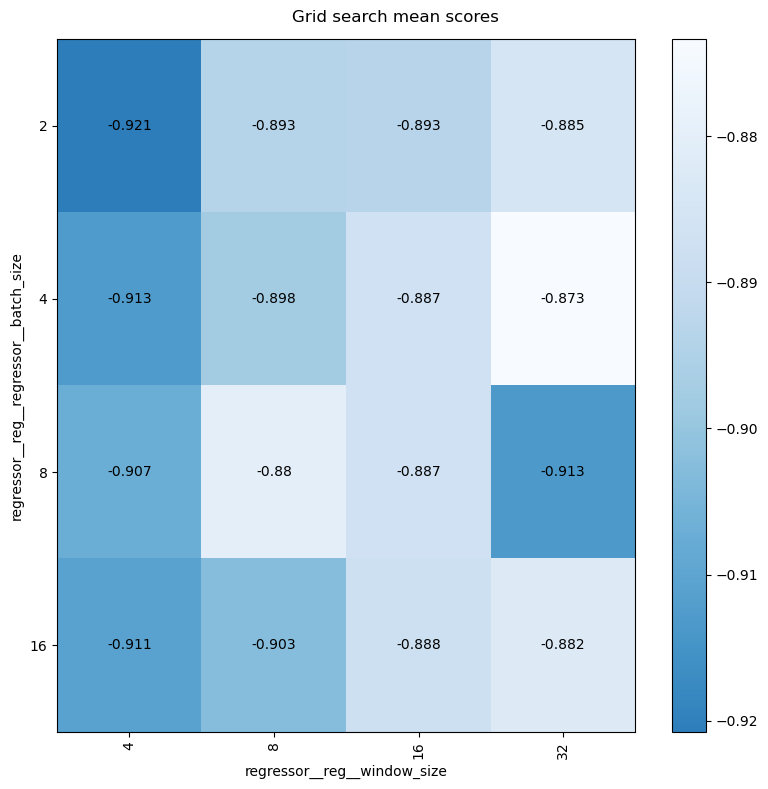

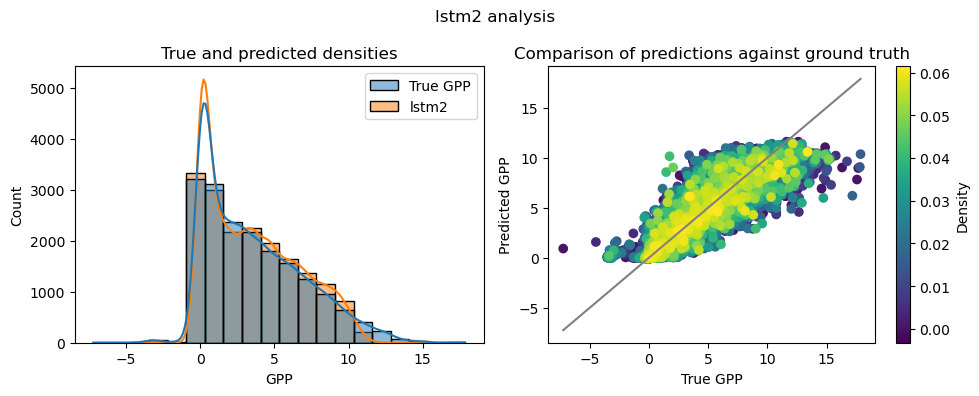

----
Predicting Test...
102/102 [==============================] - 1s 4ms/step
Prediction time: 0.65s
Score (Test): 0.82
MAE (Test): 1.03
RMSE (Test): 1.96


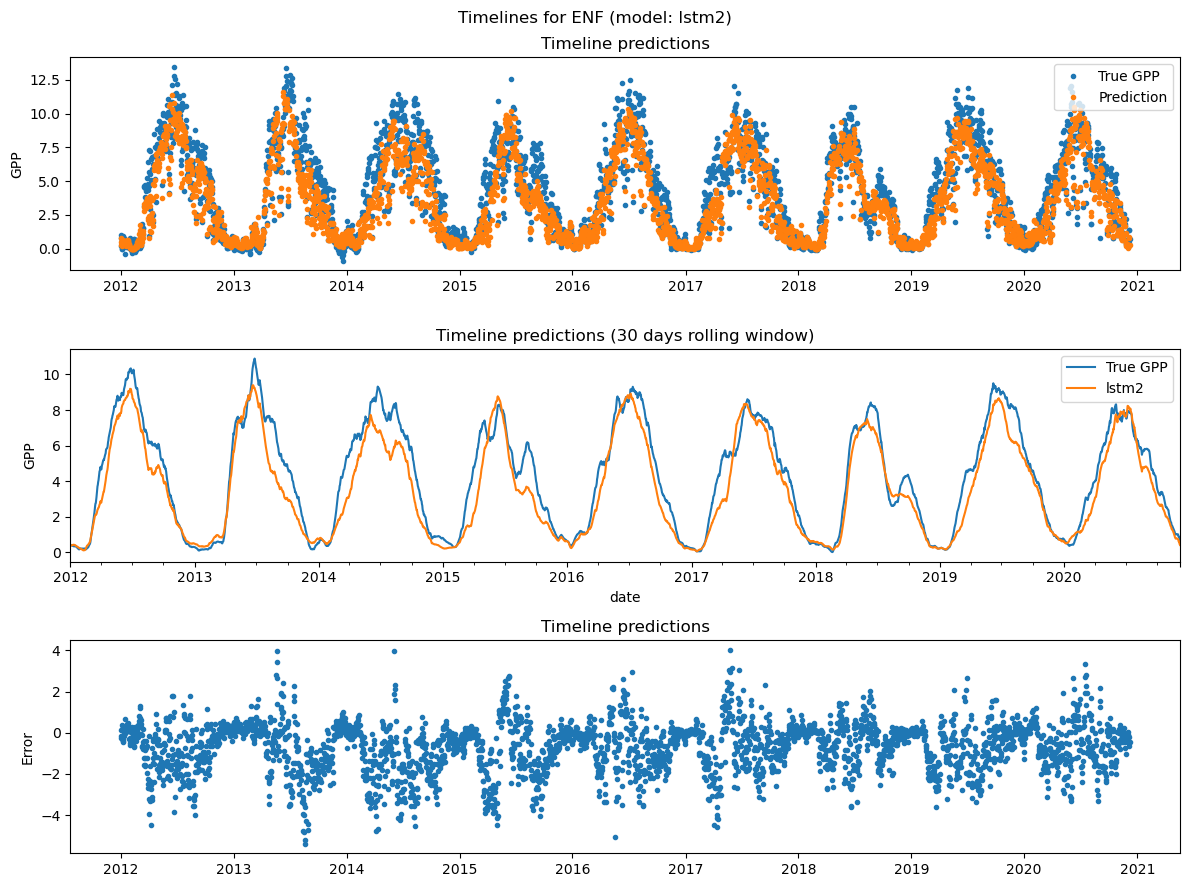

In [199]:
name = "lstm2"

grid = make_grid(
    [
        QuantileTransformer(output_distribution="normal"),
    ],
    {
        "reg__window_size": [4, 8, 16, 32],  # Total window size
        "reg__regressor__learning_rate": [0.001],
        "reg__regressor__lstm_units": [4],
        "reg__regressor__lstm_units2": [4],
        "reg__regressor__recurrent_regularizer": [0.0001],
        "reg__regressor__kernel_regularizer": [0.0001],
        "reg__regressor__batch_size": [2, 4, 8, 16],
        "reg__regressor__epochs": [100],
    },
)

model, df_pred[name], pred_time, r2, mae, rmse = eval_model(
    None,
    build_model(),
    grid,
    X_tv,
    y_tv,
    X_test,
    y_test,
    verbose=2,
    n_splits=0,
    n_jobs=1,
)
plot_curves(model.best_estimator_.regressor_.named_steps.reg.regressor.history)
hyperparam_graph(model, "reg__regressor__batch_size", xlog=True)
hyperparam_graph(model, "reg__window_size", xlog=True)
hyperparam_plot(model, ["reg__window_size", "reg__regressor__batch_size"])
pred_plot(df_pred, name)
df_pred_test[name], _, _, _, _ = compute_metrics(
    model, df_test.drop(["GPP"], axis=1), df_pred_test["True GPP"], label="Test"
)
plot_timeline(df_pred_test, name, "ENF")
ding("DONE")

## LTSM + Dense

In [168]:
def model_fun(
    lstm_units,
    dense_units,
    learning_rate,
    dropout=0,
    recurrent_dropout=0,
    kernel_regularizer=0,
    recurrent_regularizer=0,
    seed=0,
):
    model = tf.keras.models.Sequential(
        [
            # Shape [batch, time, features] => [batch, time, lstm_units]
            tf.keras.layers.LSTM(
                lstm_units,
                return_sequences=True,
                dropout=dropout,
                recurrent_dropout=recurrent_dropout,
                kernel_regularizer=tf.keras.regularizers.L2(kernel_regularizer),
                recurrent_regularizer=tf.keras.regularizers.L2(recurrent_regularizer),
                # seed=seed
            ),
            tf.keras.layers.Dense(
                units=dense_units,
                activation="relu",
                kernel_regularizer=tf.keras.regularizers.L2(kernel_regularizer),
            ),
            # Shape => [batch, time, features]
            tf.keras.layers.Dense(units=1),
        ]
    )
    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        metrics=[tf.keras.metrics.MeanAbsoluteError()],
    )
    # model.summary()
    return model

In [169]:
def build_model():
    regressor = WindowRegressor(
        HistoryKerasRegressor(
            model_fun,
            verbose=1,
            shuffle=False,
            epochs=100,
            callbacks=[keras.callbacks.EarlyStopping(patience=4, mode="min")],
        ),
        window_size=1,
    )
    return regressor

#### 8-32/8-64

Fitting 1 folds for each of 12 candidates, totalling 12 fits
Epoch 1/50
223/223 [==============================] - 5s 12ms/step - loss: 0.5047 - mean_absolute_error: 0.5210 - val_loss: 0.2896 - val_mean_absolute_error: 0.3964
Epoch 2/50
223/223 [==============================] - 2s 11ms/step - loss: 0.2819 - mean_absolute_error: 0.3856 - val_loss: 0.2469 - val_mean_absolute_error: 0.3637
Epoch 3/50
223/223 [==============================] - 3s 12ms/step - loss: 0.2541 - mean_absolute_error: 0.3616 - val_loss: 0.2310 - val_mean_absolute_error: 0.3494
Epoch 4/50
223/223 [==============================] - 3s 12ms/step - loss: 0.2393 - mean_absolute_error: 0.3479 - val_loss: 0.2217 - val_mean_absolute_error: 0.3400
Epoch 5/50
223/223 [==============================] - 2s 11ms/step - loss: 0.2291 - mean_absolute_error: 0.3381 - val_loss: 0.2156 - val_mean_absolute_error: 0.3336
Epoch 6/50
223/223 [==============================] - 2s 11ms/step - loss: 0.2218 - mean_absolute_error: 0.3310 - 

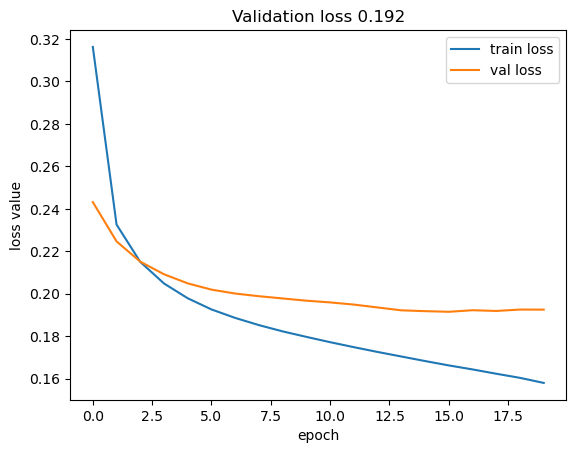

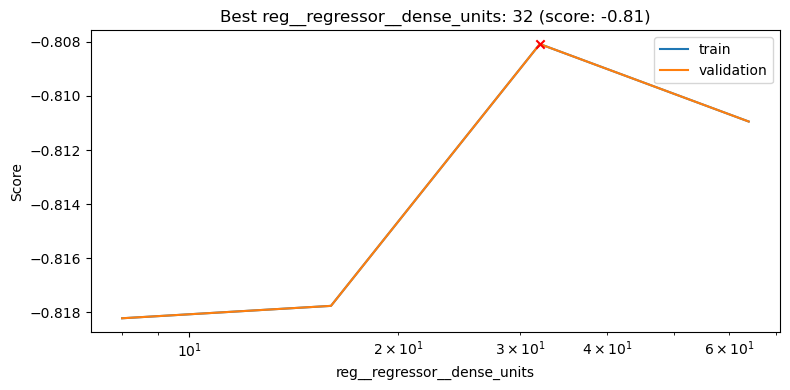

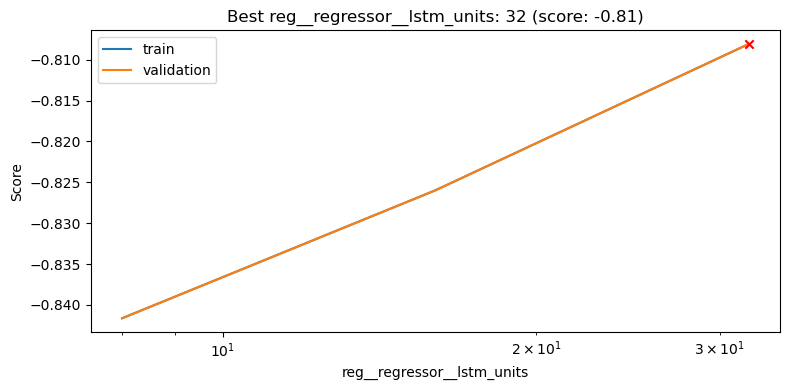

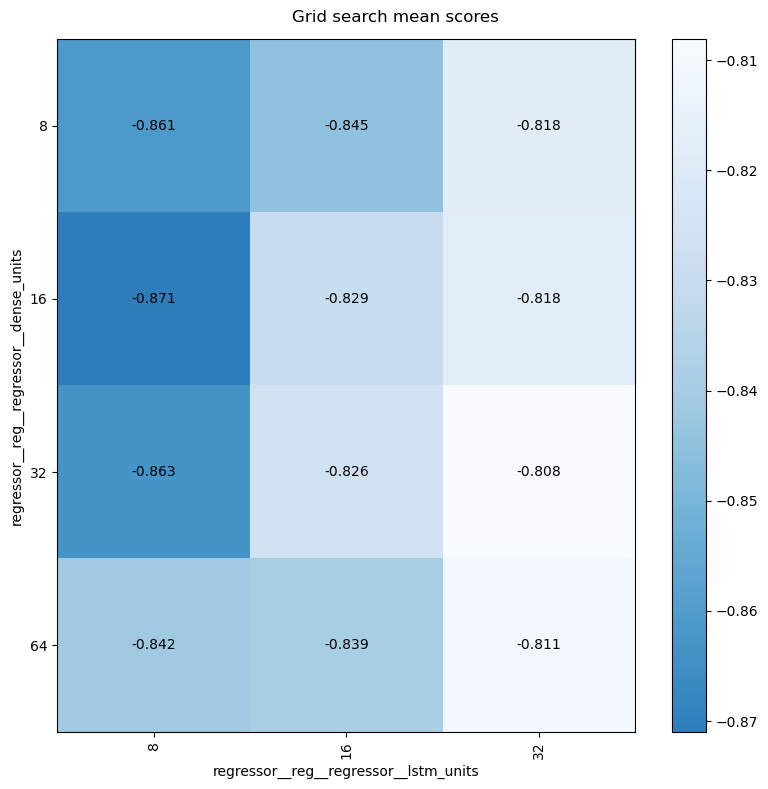

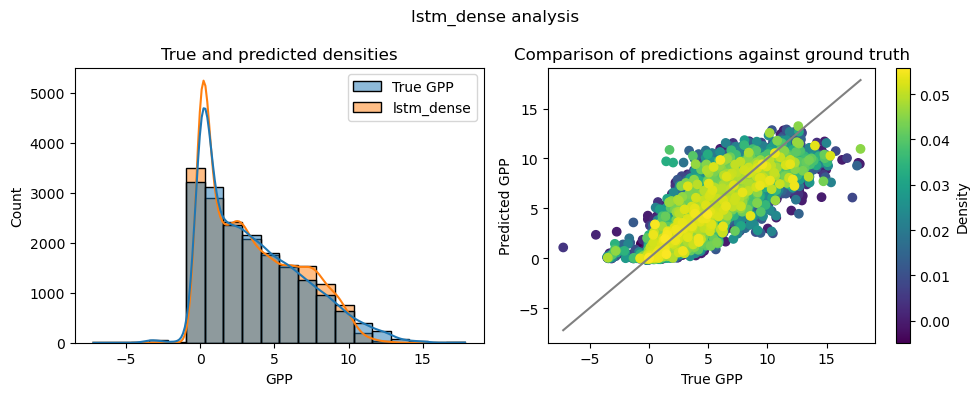

----
Predicting Test...
7/7 [==============================] - 0s 7ms/step
Prediction time: 0.24s
Score (Test): 0.83
MAE (Test): 0.96
RMSE (Test): 1.82


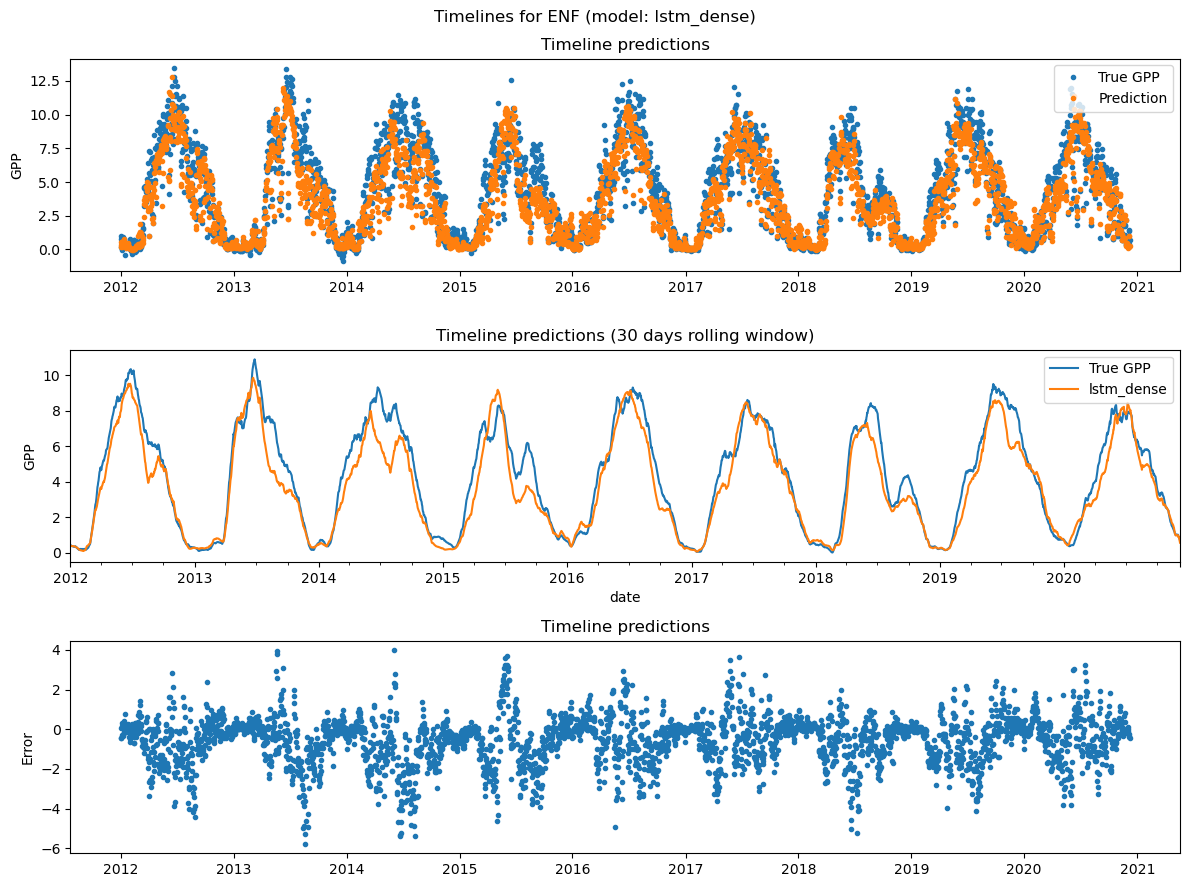

In [170]:
name = "lstm_dense"

grid = make_grid(
    [
        QuantileTransformer(output_distribution="normal"),
    ],
    {
        "reg__window_size": [MAX_WINDOW],
        "reg__window_size": [32],  # Total window size
        "reg__regressor__learning_rate": [0.001],
        "reg__regressor__lstm_units": [8, 16, 32],
        "reg__regressor__dense_units": [8, 16, 32, 64],
        "reg__regressor__recurrent_regularizer": [0.0001],
        "reg__regressor__kernel_regularizer": [0.0001],
        "reg__regressor__epochs": [50],
    },
)

model, df_pred[name], pred_time, r2, mae, rmse = eval_model(
    None,
    build_model(),
    grid,
    X_tv,
    y_tv,
    X_test,
    y_test,
    verbose=2,
    n_splits=0,
    n_jobs=1,
)
plot_net_training_curves(model.best_estimator_.regressor_.named_steps.reg.regressor.history)
hyperparam_graph(model, "reg__regressor__dense_units", xlog=True)
hyperparam_graph(model, "reg__regressor__lstm_units", xlog=True)
hyperparam_plot(
    model,
    ["reg__regressor__dense_units", "reg__regressor__lstm_units"],
)
pred_plot(df_pred, name)
df_pred_test[name], _, _, _, _ = compute_metrics(
    model, df_test.drop(["GPP"], axis=1), df_pred_test["True GPP"], label="Test"
)
plot_timeline(df_pred_test, name, "ENF")
ding("DONE!")

## Dense + LSTM

In [185]:
def model_fun(
    lstm_units,
    dense_units,
    learning_rate,
    dropout=0,
    recurrent_dropout=0,
    kernel_regularizer=0,
    recurrent_regularizer=0,
    seed=0,
):
    model = tf.keras.models.Sequential(
        [
            tf.keras.layers.Dense(
                units=dense_units,
                activation="relu",
                kernel_regularizer=tf.keras.regularizers.L2(kernel_regularizer),
            ),
            tf.keras.layers.LSTM(
                lstm_units,
                return_sequences=True,
                dropout=dropout,
                recurrent_dropout=recurrent_dropout,
                kernel_regularizer=tf.keras.regularizers.L2(kernel_regularizer),
                recurrent_regularizer=tf.keras.regularizers.L2(recurrent_regularizer),
                # seed=seed
            ),
            # Shape => [batch, time, features]
            tf.keras.layers.Dense(units=1),
        ]
    )
    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        metrics=[tf.keras.metrics.MeanAbsoluteError()],
    )
    # model.summary()
    return model

In [188]:
def build_model():
    regressor = WindowRegressor(
        HistoryKerasRegressor(
            model_fun,
            verbose=1,
            shuffle=False,
            epochs=100,
            callbacks=[keras.callbacks.EarlyStopping(patience=4, mode="min")],
        ),
        window_size=1,
    )
    return regressor

#### 32/64

Fitting 1 folds for each of 1 candidates, totalling 1 fits
Epoch 1/50
112/112 [==============================] - 5s 28ms/step - loss: 0.3069 - mean_absolute_error: 0.3985 - val_loss: 0.2456 - val_mean_absolute_error: 0.3482
Epoch 2/50
112/112 [==============================] - 3s 24ms/step - loss: 0.2363 - mean_absolute_error: 0.3357 - val_loss: 0.2215 - val_mean_absolute_error: 0.3254
Epoch 3/50
112/112 [==============================] - 3s 25ms/step - loss: 0.2182 - mean_absolute_error: 0.3182 - val_loss: 0.2120 - val_mean_absolute_error: 0.3162
Epoch 4/50
112/112 [==============================] - 3s 25ms/step - loss: 0.2082 - mean_absolute_error: 0.3088 - val_loss: 0.2065 - val_mean_absolute_error: 0.3104
Epoch 5/50
112/112 [==============================] - 3s 26ms/step - loss: 0.2012 - mean_absolute_error: 0.3021 - val_loss: 0.2027 - val_mean_absolute_error: 0.3064
Epoch 6/50
112/112 [==============================] - 3s 26ms/step - loss: 0.1958 - mean_absolute_error: 0.2969 - va

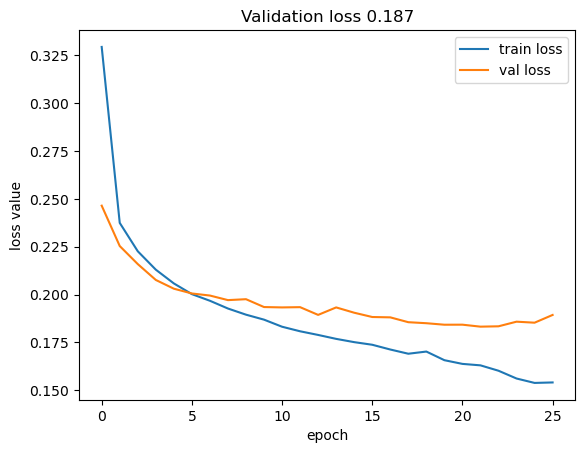

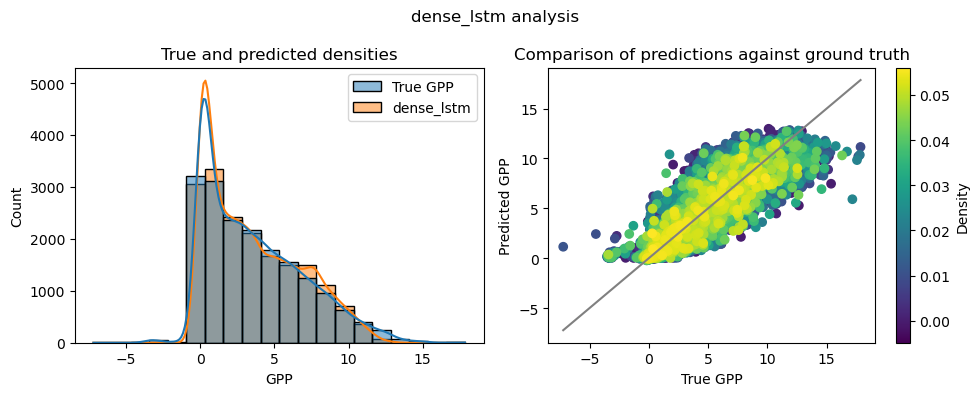

----
Predicting Test...
51/51 [==============================] - 0s 3ms/step
Prediction time: 0.42s
Score (Test): 0.81
MAE (Test): 1.03
RMSE (Test): 2.1


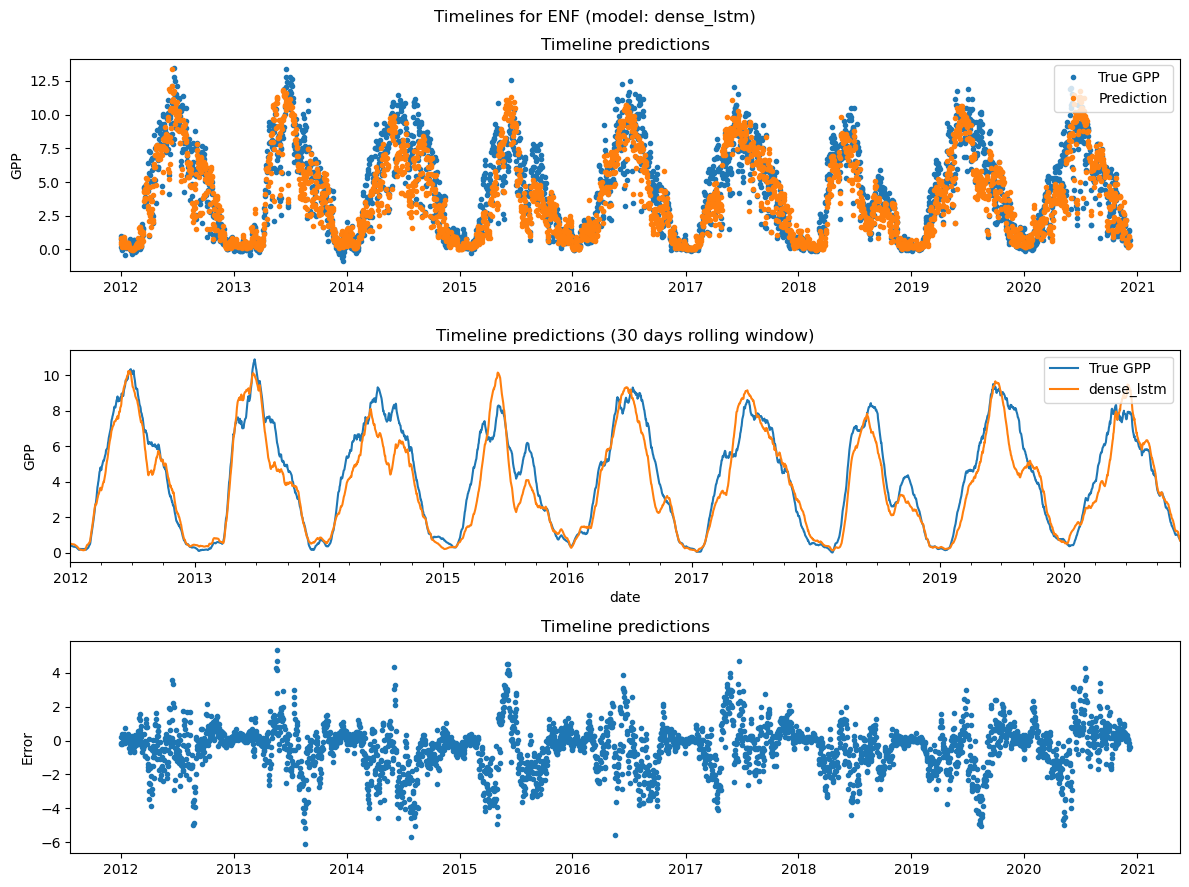

In [189]:
name = "dense_lstm"

grid = make_grid(
    [
        QuantileTransformer(output_distribution="normal"),
    ],
    {
        "reg__window_size": [MAX_WINDOW],
        "reg__window_size": [64],  # Total window size
        "reg__regressor__learning_rate": [0.001],
        "reg__regressor__lstm_units": [32],
        "reg__regressor__dense_units": [64],
        "reg__regressor__recurrent_regularizer": [0.0001],
        "reg__regressor__kernel_regularizer": [0.0001],
        "reg__regressor__epochs": [50],
    },
)

model, df_pred[name], pred_time, r2, mae, rmse = eval_model(
    None,
    build_model(),
    grid,
    X_tv,
    y_tv,
    X_test,
    y_test,
    verbose=2,
    n_splits=0,
    n_jobs=1,
)
plot_net_training_curves(model.best_estimator_.regressor_.named_steps.reg.regressor.history)
# plot_timeline(df_pred, name, "ENF")
pred_plot(df_pred, name)
df_pred_test[name], _, _, _, _ = compute_metrics(
    model, df_test.drop(["GPP"], axis=1), df_pred_test["True GPP"], label="Test"
)
plot_timeline(df_pred_test, name, "ENF")

## result

C:\Users\mayeu\miniconda3\envs\adsml\lib\site-packages\seaborn\categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


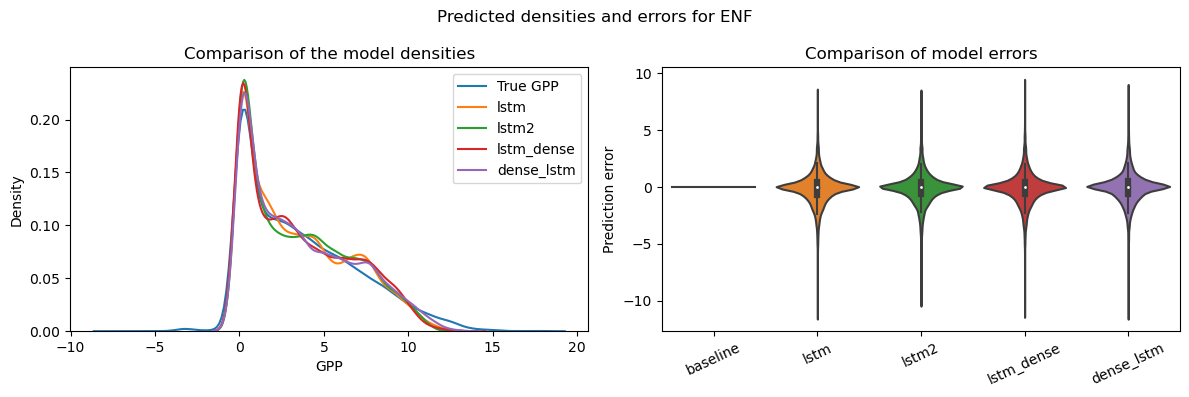

In [191]:
plot_desity_and_errors(
    df_pred, models=["lstm", "lstm2", "lstm_dense", "dense_lstm"], cover_type="ENF"
)